# AORC Gridded Precipitation Workflow

This notebook demonstrates the complete AORC (Analysis of Record for Calibration) precipitation integration workflow for HEC-HMS gridded precipitation modeling.

**Workflow Overview**:
1. **Phase 1**: Download HUC12 watersheds as subbasin templates (HmsHuc)
2. **Phase 2**: Download AORC precipitation data from AWS S3 and convert to DSS (HmsAorc)
3. **Phase 3**: Create HMS grid definition and cell mapping files (HmsGrid)
4. **Phase 4**: Execute HMS simulation and analyze peak flows (HmsCmdr, HmsResults)

**Prerequisites**:
- Internet connection (for AWS S3 and USGS web services)
- HEC-HMS 4.x installation
- Optional dependencies: `pip install hms-commander[all]`

In [1]:
# pip install hms-commander[all]

**For Development**: If working on hms-commander source code, use the `hmscmdr_local` conda environment (editable install) instead of pip install.

## Setup and Imports

In [2]:
from pathlib import Path
from datetime import datetime
import warnings
import logging

# Suppress warnings and verbose logging
warnings.filterwarnings('ignore')
logging.getLogger('botocore').setLevel(logging.WARNING)
logging.getLogger('botocore.httpchecksum').setLevel(logging.WARNING)
logging.getLogger('s3fs').setLevel(logging.WARNING)
logging.getLogger('aiobotocore').setLevel(logging.WARNING)

# HMS Commander imports
from hms_commander import HmsHuc, HmsAorc, HmsGrid, HmsExamples

# Create base output directory
base_output_dir = Path("aorc_workflow_output")
base_output_dir.mkdir(exist_ok=True)

# Extract the tenk example project (required for HMS operations)
# The tenk project is the only HMS example with gridded precipitation support
print("Extracting tenk example project (required for this workflow)...")
try:
    tenk_path = HmsExamples.extract_project("tenk")
    print(f"  Extracted to: {tenk_path}")
    
    # Set up project directories
    project_dir = tenk_path
    output_dir = project_dir / 'aorc_may_2020'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    TENK_AVAILABLE = True
except Exception as e:
    print(f"  Warning: Could not extract tenk project: {e}")
    print("  Some notebook sections will be skipped.")
    print("  Make sure HEC-HMS is installed with example projects.")
    TENK_AVAILABLE = False
    tenk_path = None
    project_dir = None
    output_dir = base_output_dir

print(f"\nOutput directory: {output_dir.absolute()}")
print(f"Workflow started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Output directory: C:\GH\hms-commander\examples\aorc_workflow_output
Workflow started: 2025-12-21 20:24:35


## Define Study Area

We'll use Bald Eagle Creek watershed in Pennsylvania as our study area. This is a well-documented watershed with multiple HUC12 subbasins.

In [3]:
# Study area bounds (west, south, east, north)
# Bald Eagle Creek, PA
bounds = (-77.71, 41.01, -77.25, 41.22)

print("Study Area: Bald Eagle Creek, PA")
print(f"  West:  {bounds[0]}Ãƒâ€šÃ‚Â°")
print(f"  South: {bounds[1]}Ãƒâ€šÃ‚Â°")
print(f"  East:  {bounds[2]}Ãƒâ€šÃ‚Â°")
print(f"  North: {bounds[3]}Ãƒâ€šÃ‚Â°")
print(f"  Width:  {abs(bounds[2] - bounds[0]):.2f}Ãƒâ€šÃ‚Â° (~{abs(bounds[2] - bounds[0]) * 85:.1f} km)")
print(f"  Height: {abs(bounds[3] - bounds[1]):.2f}Ãƒâ€šÃ‚Â° (~{abs(bounds[3] - bounds[1]) * 111:.1f} km)")

Study Area: Bald Eagle Creek, PA
  West:  -77.71Ãƒâ€šÃ‚Â°
  South: 41.01Ãƒâ€šÃ‚Â°
  East:  -77.25Ãƒâ€šÃ‚Â°
  North: 41.22Ãƒâ€šÃ‚Â°
  Width:  0.46Ãƒâ€šÃ‚Â° (~39.1 km)
  Height: 0.21Ãƒâ€šÃ‚Â° (~23.3 km)


---

## Phase 1: Download HUC12 Watersheds

HUC12 (Hydrologic Unit Code, 12-digit) watersheds from the USGS Watershed Boundary Dataset serve as our subbasin templates. Each HUC12 typically ranges from 10,000-40,000 acres.

In [4]:
# Download HUC12 watersheds for study area
print("Downloading HUC12 watersheds from USGS WBD...")
watersheds = HmsHuc.get_huc12_for_bounds(bounds)

print(f"\nDownloaded {len(watersheds)} HUC12 watersheds")
print(f"Total area: {watersheds['areasqkm'].sum():.1f} kmÃƒâ€šÃ‚Â²")

2025-12-21 20:24:38 - hms_commander.HmsHuc - INFO - Downloading HUC12 watersheds for bounds: (-77.71, 41.01, -77.25, 41.22)


2025-12-21 20:24:38 - hms_commander.HmsHuc - INFO - Downloaded 23 HUC12 watersheds



Downloaded 23 HUC12 watersheds
Total area: 2150.5 kmÃƒâ€šÃ‚Â²


In [5]:
# Display watershed summary
display_cols = ['huc12', 'name', 'areasqkm']
watersheds[display_cols].head(10)

,huc12,name,areasqkm
0,020502030404,Baker Run,47.87
1,020502030405,North Fork Tangascootack Creek,49.10
2,020502030406,Tangascootack Creek,45.92
3,020502030407,Lick Run,98.74
4,020502030408,Ferney Run-West Branch Susquehanna River,66.99
5,020502030410,McElhattan Creek,53.17
6,020502030409,Queens Run,47.22
7,020502030411,Chatham Run,61.41
8,020502030412,Reeds Run-West Branch Susquehanna River,91.62
9,020502040205,Beech Creek,127.38


In [6]:
# Get HUC information
huc_info = HmsHuc.get_huc_info()
print("HUC Levels Available:")
for level, info in huc_info.items():
    print(f"  {level}: {info['name']} - {info['description']}")

HUC Levels Available:
  huc2: Region - Major drainage basins
  huc4: Subregion - Large watershed groups
  huc6: Basin - Medium watersheds
  huc8: Subbasin - Small watersheds (good for regional HMS)
  huc10: Watershed - Local drainage areas
  huc12: Subwatershed - Catchments (good for detailed HMS)


### Visualize Watersheds (Optional)

If geopandas is installed, we can visualize the HUC12 boundaries.

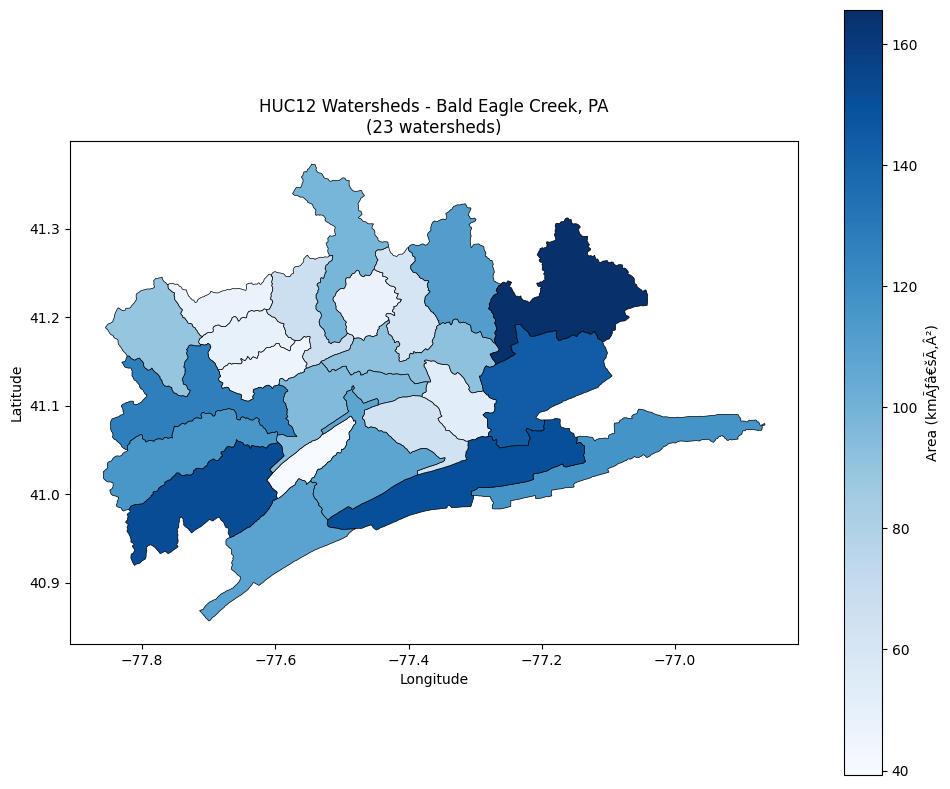

Saved: aorc_workflow_output\huc12_watersheds.png


In [7]:
try:
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(10, 8))
    watersheds.plot(ax=ax, edgecolor='black', linewidth=0.5, 
                    column='areasqkm', cmap='Blues', legend=True,
                    legend_kwds={'label': 'Area (kmÃƒâ€šÃ‚Â²)'})
    ax.set_title(f'HUC12 Watersheds - Bald Eagle Creek, PA\n({len(watersheds)} watersheds)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    plt.savefig(output_dir / 'huc12_watersheds.png', dpi=150)
    plt.show()
    print(f"Saved: {output_dir / 'huc12_watersheds.png'}")
except ImportError:
    print("matplotlib not installed - skipping visualization")

---

## Phase 2: AORC Precipitation Data

AORC (Analysis of Record for Calibration) provides hourly, ~1km gridded precipitation data for CONUS from 1979-present, hosted on AWS S3.

### 2a. Generate Storm Catalog

First, let's identify significant storm events in our study area.

In [8]:
# Get AORC dataset information
aorc_info = HmsAorc.get_info()
print("AORC Dataset Information:")
print(f"  Name: {aorc_info['name']}")
print(f"  Source: {aorc_info['source']}")
print(f"  Coverage: {aorc_info['coverage']['spatial']}")
print(f"  Resolution: {aorc_info['resolution']['spatial']}, {aorc_info['resolution']['temporal']}")
print(f"  Primary Variable: APCP_surface - {aorc_info['variables']['APCP_surface']}")

AORC Dataset Information:
  Name: Analysis of Record for Calibration (AORC)
  Source: s3://noaa-nws-aorc-v1-1-1km/
  Coverage: Continental US (CONUS) and Alaska
  Resolution: 30 arc-seconds (~800 meters), Hourly
  Primary Variable: APCP_surface - Hourly total precipitation (kg/m²)


In [9]:
# Generate storm catalog for 2020
print("Generating storm catalog for 2020...")
print("(This may take 30-60 seconds to query AWS S3)")

storms = HmsAorc.get_storm_catalog(bounds, year=2020)

print(f"\nFound {len(storms)} significant storm events")
print(f"Total precipitation depth range: {storms['total_depth_in'].min():.2f} - {storms['total_depth_in'].max():.2f} inches")

Generating storm catalog for 2020...
(This may take 30-60 seconds to query AWS S3)


2025-12-21 20:24:40 - hms_commander.HmsAorc - INFO - Generating storm catalog for 2020


2025-12-21 20:24:40 - hms_commander.HmsAorc - INFO -   Bounds: W=-77.7100, S=41.0100, E=-77.2500, N=41.2200


2025-12-21 20:24:40 - hms_commander.HmsAorc - INFO -   Parameters: inter_event=8.0h, min_depth=0.5in, buffer=48h


2025-12-21 20:24:40 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:40 - hms_commander.HmsAorc - INFO - Loading s3://noaa-nws-aorc-v1-1-1km/2020.zarr...


2025-12-21 20:24:41 - hms_commander.HmsAorc - INFO - Loading spatial subset...


2025-12-21 20:24:42 - hms_commander.HmsAorc - INFO - Loaded 8784 hourly timesteps


2025-12-21 20:24:42 - hms_commander.HmsAorc - INFO - Identified 142 raw events


2025-12-21 20:24:42 - hms_commander.HmsAorc - INFO - Storm catalog complete: 24 storms


2025-12-21 20:24:42 - hms_commander.HmsAorc - INFO -   Total depth range: 0.53 - 2.70 inches


2025-12-21 20:24:42 - hms_commander.HmsAorc - INFO -   Largest storm: 2020-12-24 12:00:00 (2.70 in)



Found 24 significant storm events
Total precipitation depth range: 0.53 - 2.70 inches


In [10]:
# Display top 10 storms by total depth
display_cols = ['storm_id', 'start_time', 'end_time', 'duration_hours', 'total_depth_in', 'rank']
storms[display_cols].head(10)

,storm_id,start_time,end_time,duration_hours,total_depth_in,rank
0,1,2020-01-25 07:00:00,2020-01-25 16:00:00,10,0.703,16
1,2,2020-02-07 09:00:00,2020-02-07 17:00:00,9,0.991,9
2,3,2020-02-10 02:00:00,2020-02-11 02:00:00,25,0.611,18
3,4,2020-02-27 03:00:00,2020-02-27 10:00:00,8,0.580,19
4,5,2020-03-19 01:00:00,2020-03-19 10:00:00,10,0.757,13
5,6,2020-03-20 03:00:00,2020-03-20 21:00:00,19,0.574,21
6,7,2020-03-28 08:00:00,2020-03-29 11:00:00,28,1.498,6
7,8,2020-04-17 17:00:00,2020-04-18 08:00:00,16,0.715,14
8,9,2020-04-26 09:00:00,2020-04-27 01:00:00,17,0.770,12
9,10,2020-04-30 04:00:00,2020-05-01 00:00:00,21,2.120,2


### Storm Catalog Visualization

Generate comprehensive visualizations of all storm events, including:
- Summary bar charts (total depth, peak intensity, duration)
- Storm timeline showing when events occurred
- Individual hyetographs for each storm

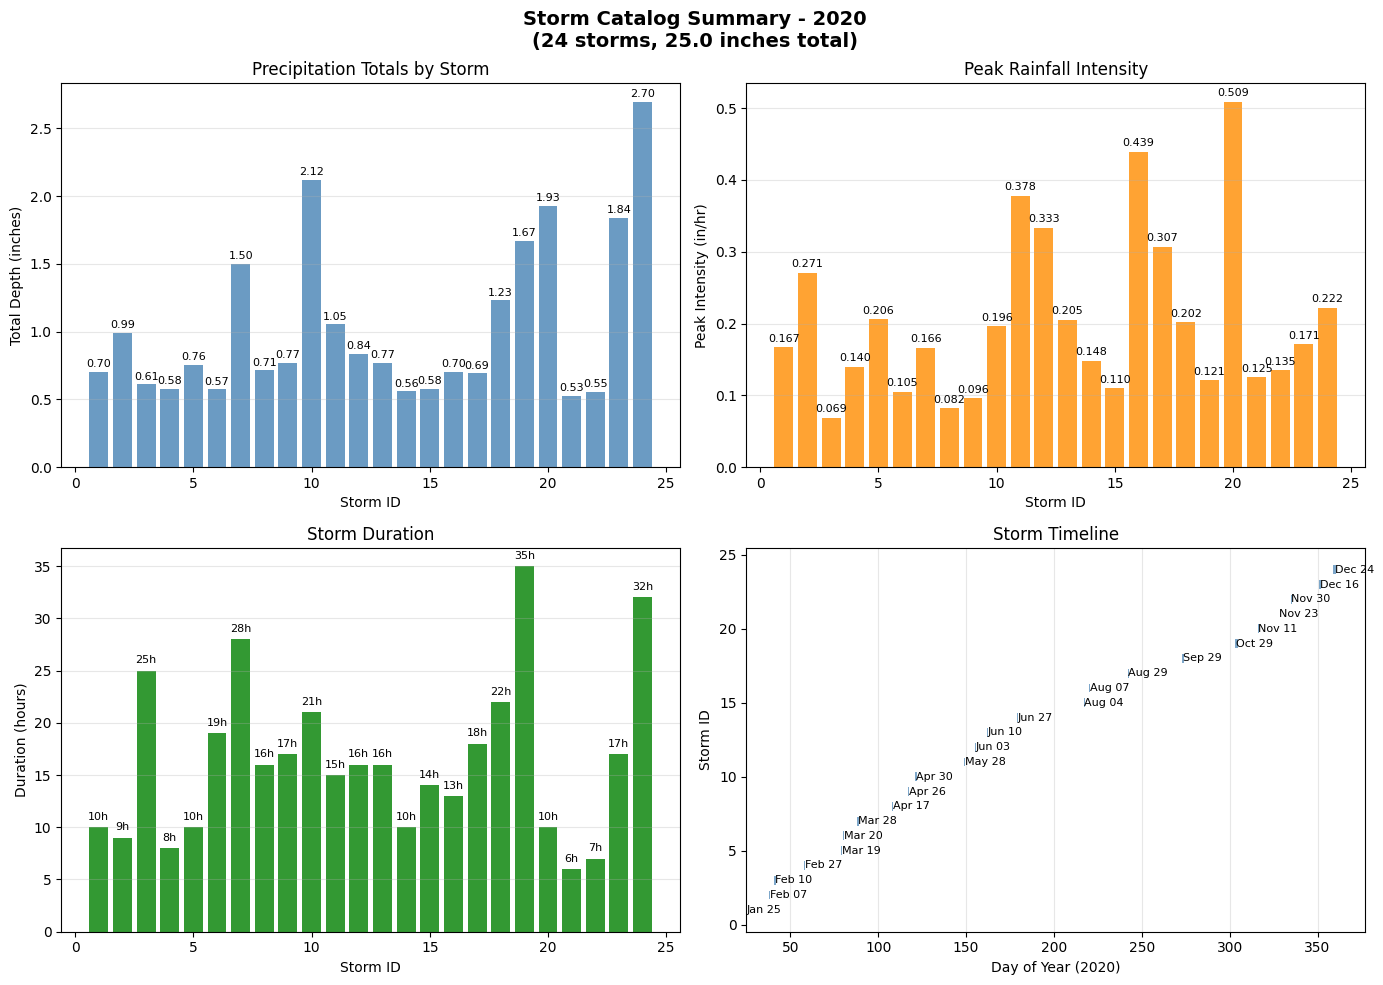

Saved: aorc_workflow_output\storm_catalog_summary.png


In [11]:
# Create storm catalog summary visualization (like ras-commander 901 notebook)
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Total depth by storm
ax1 = axes[0, 0]
bars1 = ax1.bar(storms['storm_id'], storms['total_depth_in'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Storm ID')
ax1.set_ylabel('Total Depth (inches)')
ax1.set_title('Precipitation Totals by Storm')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, storms['total_depth_in']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.2f}',
             ha='center', va='bottom', fontsize=8)

# 2. Peak intensity
ax2 = axes[0, 1]
bars2 = ax2.bar(storms['storm_id'], storms['peak_intensity_in_hr'], color='darkorange', alpha=0.8)
ax2.set_xlabel('Storm ID')
ax2.set_ylabel('Peak Intensity (in/hr)')
ax2.set_title('Peak Rainfall Intensity')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, storms['peak_intensity_in_hr']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}',
             ha='center', va='bottom', fontsize=8)

# 3. Duration
ax3 = axes[1, 0]
bars3 = ax3.bar(storms['storm_id'], storms['duration_hours'], color='green', alpha=0.8)
ax3.set_xlabel('Storm ID')
ax3.set_ylabel('Duration (hours)')
ax3.set_title('Storm Duration')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, storms['duration_hours']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.0f}h',
             ha='center', va='bottom', fontsize=8)

# 4. Timeline
ax4 = axes[1, 1]
for idx, storm in storms.iterrows():
    day_of_year = storm['start_time'].dayofyear
    ax4.barh(storm['storm_id'], storm['duration_hours']/24, left=day_of_year,
             color='steelblue', alpha=0.7, height=0.6)
    ax4.text(day_of_year + storm['duration_hours']/48, storm['storm_id'],
             storm['start_time'].strftime('%b %d'), fontsize=8, va='center')
ax4.set_xlabel('Day of Year (2020)')
ax4.set_ylabel('Storm ID')
ax4.set_title('Storm Timeline')
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle(f'Storm Catalog Summary - 2020\n({len(storms)} storms, {storms["total_depth_in"].sum():.1f} inches total)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'storm_catalog_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir / 'storm_catalog_summary.png'}")

## Cumulative Precipitation Map

This visualization shows the spatial distribution of cumulative AORC precipitation over the study area, with HMS subbasin boundaries overlaid. This helps visualize:
- Spatial variation in precipitation across the watershed
- How precipitation aligns with HMS model subbasins
- Areas of higher/lower precipitation accumulation

In [ ]:
# =============================================================================
# Cumulative Precipitation Map with HMS Subbasin Boundaries
# =============================================================================

if not TENK_AVAILABLE:
    print("Skipping this cell: tenk project not available")
    print("Please ensure HEC-HMS is installed with example projects")
else:
    from pathlib import Path
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap
    import xarray as xr
    from hms_commander import HmsAorc, HmsBasin

    print("Creating cumulative precipitation map with HMS subbasin schematic...")

    # Use the pre-extracted tenk project paths from setup
    basin_file = project_dir / 'Tenk_1.basin'

    # Tenkiller Lake area geographic bounds (eastern Oklahoma)
    # The Illinois River watershed drains into Tenkiller Lake
    bounds = (-95.2, 35.4, -94.4, 36.2)  # (west, south, east, north)
    print(f"Using Tenkiller area bounds: {bounds}")

    # Get HMS basin elements for schematic overlay
    print("\nLoading HMS basin model elements...")
    subbasins = HmsBasin.get_subbasins(basin_file)
    junctions = HmsBasin.get_junctions(basin_file)
    reaches = HmsBasin.get_reaches(basin_file)

    print(f"  Subbasins: {len(subbasins)}")
    print(f"  Junctions: {len(junctions)}")
    print(f"  Reaches: {len(reaches)}")

    # Download AORC data for one week
    nc_file = output_dir / 'aorc_cumulative_may2020.nc'
    print(f"\nDownloading AORC data for May 1-7, 2020...")

    try:
        nc_path = HmsAorc.download(
            bounds=bounds,
            start_time='2020-05-01',
            end_time='2020-05-07',
            output_path=nc_file
        )
        print(f"Downloaded: {nc_path}")

        # Load and process
        ds = xr.open_dataset(nc_path)
        print(f"Data variables: {list(ds.data_vars)}")

        # Get precipitation variable
        precip_var = 'APCP_surface' if 'APCP_surface' in ds else list(ds.data_vars)[0]

        # Compute cumulative precipitation (sum over time)
        cumulative_precip = ds[precip_var].sum(dim='time')

        # Convert mm to inches
        cumulative_precip_inches = cumulative_precip / 25.4

        print(f"Cumulative range: {float(cumulative_precip_inches.min()):.2f} to {float(cumulative_precip_inches.max()):.2f} inches")

        # Get coordinates
        if 'longitude' in ds.coords:
            lons = ds.longitude.values
            lats = ds.latitude.values
        elif 'x' in ds.coords:
            lons = ds.x.values
            lats = ds.y.values
        else:
            coord_names = [d for d in ds.dims if d != 'time']
            lons = ds.coords[coord_names[-1]].values
            lats = ds.coords[coord_names[0]].values

        print(f"Grid: {len(lons)} x {len(lats)} cells")

        # Create figure with two panels
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Panel 1: Cumulative precipitation map
        ax1 = axes[0]
        precip_colors = ['#ffffff', '#c6dbef', '#6baed6', '#2171b5', '#08306b']
        precip_cmap = LinearSegmentedColormap.from_list('precip', precip_colors)

        lon_grid, lat_grid = np.meshgrid(lons, lats)
        mesh = ax1.pcolormesh(
            lon_grid, lat_grid,
            cumulative_precip_inches.values,
            cmap=precip_cmap,
            shading='auto',
            alpha=0.85
        )

        cbar = plt.colorbar(mesh, ax=ax1, label='Cumulative Precipitation (inches)', pad=0.02)
        ax1.set_xlabel('Longitude', fontsize=12)
        ax1.set_ylabel('Latitude', fontsize=12)
        ax1.set_title('AORC Cumulative Precipitation\nMay 1-7, 2020', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, linestyle='--')

        # Add location labels
        locations = [
            ('Tahlequah', -94.97, 35.92),
            ('Watts', -94.57, 36.12),
            ('Tenkiller Lake', -94.95, 35.60)
        ]
        for name, lon, lat in locations:
            ax1.plot(lon, lat, 'ko', markersize=6)
            ax1.annotate(name, (lon, lat), xytext=(5, 5), textcoords='offset points',
                        fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

        # Panel 2: HMS Basin Model Schematic with precipitation context
        ax2 = axes[1]

        # Get schematic bounds from basin model
        all_x = []
        all_y = []
        for _, sub in subbasins.iterrows():
            all_x.append(float(sub['canvas_x']))
            all_y.append(float(sub['canvas_y']))
        for _, junc in junctions.iterrows():
            all_x.append(float(junc['canvas_x']))
            all_y.append(float(junc['canvas_y']))

        # Normalize schematic to fit geographic extent
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)

        def scale_x(x):
            return bounds[0] + (float(x) - min_x) / (max_x - min_x) * (bounds[2] - bounds[0])

        def scale_y(y):
            return bounds[1] + (float(y) - min_y) / (max_y - min_y) * (bounds[3] - bounds[1])

        # Plot precipitation background
        mesh2 = ax2.pcolormesh(
            lon_grid, lat_grid,
            cumulative_precip_inches.values,
            cmap=precip_cmap,
            shading='auto',
            alpha=0.5
        )

        # Plot subbasins as filled circles
        for _, sub in subbasins.iterrows():
            x = scale_x(sub['canvas_x'])
            y = scale_y(sub['canvas_y'])
            area = float(sub['area'])
            size = 200 + area * 0.5
            ax2.scatter(x, y, s=size, c='royalblue', edgecolors='navy',
                       linewidths=2, alpha=0.8, zorder=10)
            ax2.annotate(sub['name'], (x, y),
                        xytext=(0, -15), textcoords='offset points',
                        fontsize=9, fontweight='bold', ha='center',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.9))

        # Plot junctions as diamonds
        for _, junc in junctions.iterrows():
            x = scale_x(junc['canvas_x'])
            y = scale_y(junc['canvas_y'])
            ax2.scatter(x, y, s=150, c='limegreen', marker='D', edgecolors='darkgreen',
                       linewidths=2, alpha=0.9, zorder=15)
            ax2.annotate(junc['name'], (x, y),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='lightgreen', alpha=0.9))

        # Plot reaches as arrows
        for _, reach in reaches.iterrows():
            from_x = scale_x(reach.get('from_canvas_x', reach['canvas_x']))
            from_y = scale_y(reach.get('from_canvas_y', reach['canvas_y']))
            to_x = scale_x(reach['canvas_x'])
            to_y = scale_y(reach['canvas_y'])
            ax2.annotate('', xy=(to_x, to_y), xytext=(from_x, from_y),
                        arrowprops=dict(arrowstyle='->', color='darkorange', lw=2))

        ax2.set_xlabel('Longitude', fontsize=12)
        ax2.set_ylabel('Latitude', fontsize=12)
        ax2.set_title('HMS Basin Model Schematic\nOverlaid on AORC Precipitation', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.set_xlim(bounds[0], bounds[2])
        ax2.set_ylim(bounds[1], bounds[3])

        # Legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue',
                      markersize=12, markeredgecolor='navy', markeredgewidth=2, label='Subbasin'),
            plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='limegreen',
                      markersize=10, markeredgecolor='darkgreen', markeredgewidth=2, label='Junction'),
            plt.Line2D([0], [0], color='darkorange', linewidth=2, label='Reach'),
        ]
        ax2.legend(handles=legend_elements, loc='upper right', fontsize=10)

        plt.tight_layout()

        output_file = output_dir / 'cumulative_precipitation_map.png'
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        print(f"\nSaved: {output_file}")

        plt.show()
        ds.close()

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

### Individual Storm Hyetographs

Generate hyetograph (precipitation intensity vs time) plots for each storm event.

In [13]:
import pandas as pd
# Create hyetographs folder
hyetograph_dir = output_dir / "hyetographs"
hyetograph_dir.mkdir(exist_ok=True)

# Generate individual hyetograph for each storm
print(f"Generating hyetograph plots for {len(storms)} storms...")
print("=" * 70)

for idx, storm in storms.iterrows():
    storm_id = storm['storm_id']
    date_str = storm['start_time'].strftime('%Y%m%d')
    storm_nc = hyetograph_dir / f"storm_{date_str}.nc"

    try:
        # Download if not exists
        if not storm_nc.exists():
            HmsAorc.download(
                bounds=bounds,
                start_time=storm['start_time'],
                end_time=storm['end_time'],
                output_path=storm_nc
            )

        # Load and plot
        import xarray as xr
        ds = xr.open_dataset(storm_nc)
        da = ds['APCP_surface']
        hourly_mean = da.mean(dim=[d for d in da.dims if d != 'time']).values
        times = pd.to_datetime(da.time.values)

        fig, ax = plt.subplots(figsize=(12, 5))
        ax.bar(times, hourly_mean, width=0.03, color='steelblue', alpha=0.8,
               edgecolor='darkblue', linewidth=0.5)

        ax.set_title(f"Storm {storm_id}: {storm['start_time'].strftime('%B %d, %Y')}\n"
                     f"Total: {storm['total_depth_in']:.2f} in | Peak: {storm['peak_intensity_in_hr']:.3f} in/hr | "
                     f"Duration: {storm['duration_hours']:.0f} hours", fontsize=12, fontweight='bold')
        ax.set_xlabel('Date/Time', fontsize=11)
        ax.set_ylabel('Precipitation Rate (mm/hr)', fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

        stats_text = (f"Max Rate: {hourly_mean.max():.2f} mm/hr\n"
                      f"Total: {hourly_mean.sum():.1f} mm\n"
                      f"Timesteps: {len(hourly_mean)}")
        ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        plt.tight_layout()
        plot_path = hyetograph_dir / f"storm_{date_str}_hyetograph.png"
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()
        ds.close()
        print(f"  Storm {storm_id:2d}: {storm['start_time'].strftime('%b %d')} - Saved")

    except Exception as e:
        print(f"  Storm {storm_id:2d}: Error - {e}")
        plt.close()

print(f"\nHyetographs saved to: {hyetograph_dir}")

2025-12-21 20:24:43 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:43 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Time range: 2020-01-25 07:00:00 to 2020-01-25 16:00:00


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Time range: 2020-01-25 07:00:00 to 2020-01-25 16:00:00


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


Generating hyetograph plots for 24 storms...


2025-12-21 20:24:43 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:43 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:43 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:43 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Time range: 2020-02-07 09:00:00 to 2020-02-07 17:00:00


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Time range: 2020-02-07 09:00:00 to 2020-02-07 17:00:00


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:43 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  1: Error - No data found for the specified bounds and time range


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Time range: 2020-02-10 02:00:00 to 2020-02-11 02:00:00


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Time range: 2020-02-10 02:00:00 to 2020-02-11 02:00:00


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  2: Error - No data found for the specified bounds and time range


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Time range: 2020-02-27 03:00:00 to 2020-02-27 10:00:00


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Time range: 2020-02-27 03:00:00 to 2020-02-27 10:00:00


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  3: Error - No data found for the specified bounds and time range


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:44 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Time range: 2020-03-19 01:00:00 to 2020-03-19 10:00:00


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Time range: 2020-03-19 01:00:00 to 2020-03-19 10:00:00


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:44 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  4: Error - No data found for the specified bounds and time range


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-03-20 03:00:00 to 2020-03-20 21:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-03-20 03:00:00 to 2020-03-20 21:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  5: Error - No data found for the specified bounds and time range


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-03-28 08:00:00 to 2020-03-29 11:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-03-28 08:00:00 to 2020-03-29 11:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  6: Error - No data found for the specified bounds and time range


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-04-17 17:00:00 to 2020-04-18 08:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-04-17 17:00:00 to 2020-04-18 08:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  7: Error - No data found for the specified bounds and time range


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-04-26 09:00:00 to 2020-04-27 01:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Time range: 2020-04-26 09:00:00 to 2020-04-27 01:00:00


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:45 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  8: Error - No data found for the specified bounds and time range


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-04-30 04:00:00 to 2020-05-01 00:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-04-30 04:00:00 to 2020-05-01 00:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm  9: Error - No data found for the specified bounds and time range


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-05-28 12:00:00 to 2020-05-29 02:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-05-28 12:00:00 to 2020-05-29 02:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 10: Error - No data found for the specified bounds and time range


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-06-03 06:00:00 to 2020-06-03 21:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-06-03 06:00:00 to 2020-06-03 21:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 11: Error - No data found for the specified bounds and time range


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-06-10 17:00:00 to 2020-06-11 08:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Time range: 2020-06-10 17:00:00 to 2020-06-11 08:00:00


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:46 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 12: Error - No data found for the specified bounds and time range


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-06-27 09:00:00 to 2020-06-27 18:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-06-27 09:00:00 to 2020-06-27 18:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 13: Error - No data found for the specified bounds and time range


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-08-04 09:00:00 to 2020-08-04 22:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-08-04 09:00:00 to 2020-08-04 22:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 14: Error - No data found for the specified bounds and time range


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-08-07 01:00:00 to 2020-08-07 13:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-08-07 01:00:00 to 2020-08-07 13:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 15: Error - No data found for the specified bounds and time range


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-08-29 04:00:00 to 2020-08-29 21:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Time range: 2020-08-29 04:00:00 to 2020-08-29 21:00:00


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:47 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 16: Error - No data found for the specified bounds and time range


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-09-29 11:00:00 to 2020-09-30 08:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-09-29 11:00:00 to 2020-09-30 08:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 17: Error - No data found for the specified bounds and time range


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-10-29 08:00:00 to 2020-10-30 18:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-10-29 08:00:00 to 2020-10-30 18:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 18: Error - No data found for the specified bounds and time range


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-11-11 13:00:00 to 2020-11-11 22:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-11-11 13:00:00 to 2020-11-11 22:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 19: Error - No data found for the specified bounds and time range


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-11-23 03:00:00 to 2020-11-23 08:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Time range: 2020-11-23 03:00:00 to 2020-11-23 08:00:00


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:48 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 20: Error - No data found for the specified bounds and time range


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Time range: 2020-11-30 10:00:00 to 2020-11-30 16:00:00


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Time range: 2020-11-30 10:00:00 to 2020-11-30 16:00:00


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 21: Error - No data found for the specified bounds and time range


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Time range: 2020-12-16 17:00:00 to 2020-12-17 09:00:00


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Time range: 2020-12-16 17:00:00 to 2020-12-17 09:00:00


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 22: Error - No data found for the specified bounds and time range


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Time range: 2020-12-24 12:00:00 to 2020-12-25 19:00:00


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Time range: 2020-12-24 12:00:00 to 2020-12-25 19:00:00


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:49 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Storm 23: Error - No data found for the specified bounds and time range


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:49 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


  Storm 24: Error - No data found for the specified bounds and time range

Hyetographs saved to: hms_example_projects\tenk\aorc_may_2020\hyetographs


### Display Top Storms Hyetographs

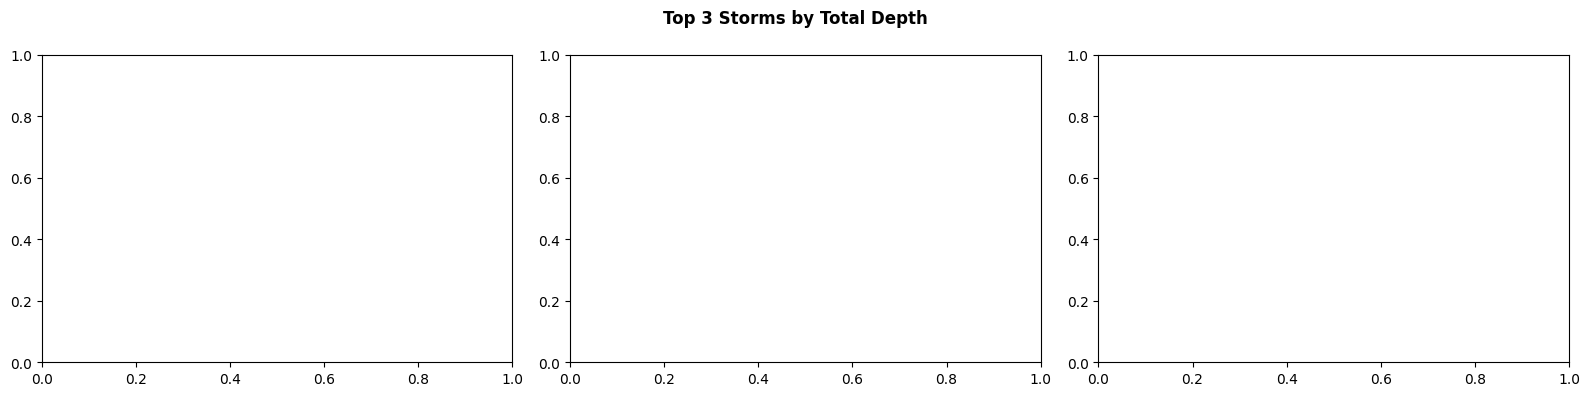

Saved: hms_example_projects\tenk\aorc_may_2020\top_storms_hyetographs.png


In [14]:
# Display the top 3 storms by total depth
top_storms = storms.nlargest(3, 'total_depth_in')

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, (idx, storm) in enumerate(top_storms.iterrows()):
    ax = axes[i]
    storm_id = storm['storm_id']
    date_str = storm['start_time'].strftime('%Y%m%d')
    storm_nc = hyetograph_dir / f"storm_{date_str}.nc"

    if storm_nc.exists():
        import xarray as xr
        ds = xr.open_dataset(storm_nc)
        da = ds['APCP_surface']
        hourly_mean = da.mean(dim=[d for d in da.dims if d != 'time']).values

        ax.bar(range(len(hourly_mean)), hourly_mean, color='steelblue', alpha=0.8)
        ax.set_title(f"Storm {storm_id}: {storm['start_time'].strftime('%b %d')}\n"
                     f"{storm['total_depth_in']:.2f} in", fontsize=10, fontweight='bold')
        ax.set_xlabel('Hours')
        ax.set_ylabel('mm/hr')
        ax.grid(True, alpha=0.3)
        ds.close()

plt.suptitle('Top 3 Storms by Total Depth', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'top_storms_hyetographs.png', dpi=150)
plt.show()
print(f"Saved: {output_dir / 'top_storms_hyetographs.png'}")

In [15]:
# Select the largest storm for demonstration
largest_storm = storms[storms['rank'] == 1].iloc[0]

print("Selected Storm (Largest of 2020):")
print(f"  Storm ID: {largest_storm['storm_id']}")
print(f"  Start: {largest_storm['start_time']}")
print(f"  End: {largest_storm['end_time']}")
print(f"  Duration: {largest_storm['duration_hours']} hours")
print(f"  Total Depth: {largest_storm['total_depth_in']:.2f} inches")
print(f"\nRecommended Simulation Window:")
print(f"  Start: {largest_storm['sim_start']}")
print(f"  End: {largest_storm['sim_end']}")

Selected Storm (Largest of 2020):
  Storm ID: 24
  Start: 2020-12-24 12:00:00
  End: 2020-12-25 19:00:00
  Duration: 32 hours
  Total Depth: 2.70 inches

Recommended Simulation Window:
  Start: 2020-12-22 12:00:00
  End: 2020-12-27 19:00:00


### 2b. Download AORC Data

Download the AORC precipitation data for the selected storm event.

In [16]:
# Download AORC data for the storm
nc_file = output_dir / "aorc_storm.nc"

print(f"Downloading AORC data from AWS S3...")
print(f"  Bounds: {bounds}")
print(f"  Period: {largest_storm['sim_start']} to {largest_storm['sim_end']}")

nc_result = HmsAorc.download(
    bounds=bounds,
    start_time=str(largest_storm['sim_start']),
    end_time=str(largest_storm['sim_end']),
    output_path=nc_file
)

print(f"\nDownload complete!")
print(f"  File: {nc_result}")
print(f"  Size: {nc_result.stat().st_size / (1024*1024):.2f} MB")

2025-12-21 20:24:50 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:50 - hms_commander.HmsAorc - WARNING - Bounds (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1)) may extend outside CONUS coverage (-125.0, 25.0, -67.0, 53.0)


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO - Downloading AORC data:


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Bounds: W=-0.1000, S=57.3690, E=460.7340, N=500.1000


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Time range: 2020-12-22 12:00:00 to 2020-12-27 19:00:00


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Time range: 2020-12-22 12:00:00 to 2020-12-27 19:00:00


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Variable: APCP_surface


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO - Connecting to AWS S3...


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


2025-12-21 20:24:50 - hms_commander.HmsAorc - INFO -   Loading year 2020 from s3://noaa-nws-aorc-v1-1-1km/2020.zarr


  Bounds: (np.float64(-0.1), np.float64(57.369), np.float64(460.73400000000004), np.float64(500.1))
  Period: 2020-12-22 12:00:00 to 2020-12-27 19:00:00


2025-12-21 20:24:50 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


2025-12-21 20:24:50 - hms_commander.HmsAorc - WARNING -     No data found for year 2020


ValueError: No data found for the specified bounds and time range

In [16]:
# Examine the NetCDF file
try:
    import xarray as xr
    
    ds = xr.open_dataset(nc_file)
    print("NetCDF Structure:")
    print(ds)
    
    # Get grid dimensions
    lon_dim = 'longitude' if 'longitude' in ds.dims else 'lon' if 'lon' in ds.dims else 'x'
    lat_dim = 'latitude' if 'latitude' in ds.dims else 'lat' if 'lat' in ds.dims else 'y'
    time_dim = 'time' if 'time' in ds.dims else 'valid_time'
    
    print(f"\nGrid Dimensions:")
    print(f"  Longitude: {len(ds[lon_dim])} cells ({float(ds[lon_dim].min()):.4f}Ãƒâ€šÃ‚Â° to {float(ds[lon_dim].max()):.4f}Ãƒâ€šÃ‚Â°)")
    print(f"  Latitude: {len(ds[lat_dim])} cells ({float(ds[lat_dim].min()):.4f}Ãƒâ€šÃ‚Â° to {float(ds[lat_dim].max()):.4f}Ãƒâ€šÃ‚Â°)")
    print(f"  Time: {len(ds[time_dim])} timesteps")
    
    ds.close()
except Exception as e:
    print(f"Could not examine NetCDF: {e}")

NetCDF Structure:
<xarray.Dataset> Size: 2MB
Dimensions:       (time: 144, latitude: 25, longitude: 55)
Coordinates:
  * time          (time) datetime64[ns] 1kB 2020-12-22 ... 2020-12-27T23:00:00
  * latitude      (latitude) float64 200B 41.02 41.02 41.03 ... 41.2 41.21 41.22
  * longitude     (longitude) float64 440B -77.7 -77.69 -77.69 ... -77.26 -77.25
Data variables:
    APCP_surface  (time, latitude, longitude) float64 2MB ...

Grid Dimensions:
  Longitude: 55 cells (-77.7021Ãƒâ€šÃ‚Â° to -77.2521Ãƒâ€šÃ‚Â°)
  Latitude: 25 cells (41.0158Ãƒâ€šÃ‚Â° to 41.2158Ãƒâ€šÃ‚Â°)
  Time: 144 timesteps


### 2c. Convert to DSS Grid

Convert the NetCDF to HMS-compatible DSS grid format using HEC Monolith libraries.

In [17]:
# Convert NetCDF to DSS grid
dss_file = output_dir / "aorc_storm.dss"

print("Converting to DSS grid format...")
print("(Using HEC Monolith via pyjnius)")

dss_result = HmsAorc.convert_to_dss_grid(
    netcdf_file=nc_file,
    output_dss_file=dss_file,
    pathname="/AORC/BALDEAGLE/PRECIP////",
    units="MM"
)

print(f"\nConversion complete!")
print(f"  File: {dss_result}")
print(f"  Size: {dss_result.stat().st_size / (1024*1024):.2f} MB")

2025-12-21 20:13:29 - hms_commander.HmsAorc - INFO - Converting AORC NetCDF to DSS grid:


2025-12-21 20:13:29 - hms_commander.HmsAorc - INFO -   Input: aorc_workflow_output\aorc_storm.nc


2025-12-21 20:13:29 - hms_commander.HmsAorc - INFO -   Output: aorc_workflow_output\aorc_storm.dss


2025-12-21 20:13:30 - hms_commander.HmsAorc - INFO -   Pathname: /AORC/BALDEAGLE/PRECIP////


2025-12-21 20:13:30 - hms_commander.HmsAorc - INFO -   Grid shape: (144, 25, 55) (time, lat, lon)


2025-12-21 20:13:30 - hms_commander.HmsAorc - INFO -   Time range: 2020-12-22 00:00:00 to 2020-12-27 23:00:00


2025-12-21 20:13:30 - hms_commander.HmsAorc - INFO -   Lat range: 41.0158 to 41.2158


2025-12-21 20:13:30 - hms_commander.HmsAorc - INFO -   Lon range: -77.7021 to -77.2521


Converting to DSS grid format...
(Using HEC Monolith via pyjnius)


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO - Configuring HEC Monolith for DSS grid writing...


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO - Configuring HEC Monolith for DSS grid writing...


Configuring Java VM for DSS operations...
  Found Java: C:\Program Files\Java\jre1.8.0_471
[OK] Java VM configured


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO - Writing DSS grid to: aorc_workflow_output\aorc_storm.dss


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO - Writing DSS grid to: aorc_workflow_output\aorc_storm.dss


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Pathname: /AORC/BALDEAGLE/PRECIP////


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Pathname: /AORC/BALDEAGLE/PRECIP////


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Grid: 25 lat x 55 lon = 1375 cells


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Grid: 25 lat x 55 lon = 1375 cells


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Timesteps: 144


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Timesteps: 144


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Cell size: 0.008333 degrees


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Cell size: 0.008333 degrees


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Origin: (-77.7021, 41.0158)


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Origin: (-77.7021, 41.0158)


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Units: MM, Type: PER-CUM


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Units: MM, Type: PER-CUM


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 10/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 10/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 20/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 20/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 30/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 30/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 40/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 40/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 50/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 50/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 60/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 60/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 70/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 70/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 80/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 80/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 90/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 90/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 100/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 100/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 110/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 110/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 120/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 120/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 130/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 130/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 140/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 140/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 144/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Wrote 144/144 timesteps


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO - DSS grid write complete: aorc_workflow_output\aorc_storm.dss


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO - DSS grid write complete: aorc_workflow_output\aorc_storm.dss


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   File size: 0.34 MB


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   File size: 0.34 MB


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Total cells: 198,000


2025-12-21 20:13:30 - hms_commander.HmsDssGrid - INFO -   Total cells: 198,000


2025-12-21 20:13:30 - hms_commander.HmsAorc - INFO - DSS conversion complete: aorc_workflow_output\aorc_storm.dss


2025-12-21 20:13:30 - hms_commander.HmsAorc - INFO - DSS conversion complete: aorc_workflow_output\aorc_storm.dss



Conversion complete!
  File: aorc_workflow_output\aorc_storm.dss
  Size: 0.34 MB


In [18]:
# Verify DSS file (optional - requires ras-commander DSS support)
try:
    from ras_commander.dss import RasDss
    
    catalog = RasDss.get_catalog(str(dss_file))
    print(f"DSS Catalog: {len(catalog)} records")
    print(f"\nSample pathnames:")
    for path in catalog[:5]:
        print(f"  {path}")
    if len(catalog) > 5:
        print(f"  ... and {len(catalog) - 5} more")
except Exception as e:
    print(f"Could not read DSS catalog: {e}")

DSS Catalog: 144 records

Sample pathnames:
  /AORC/BALDEAGLE/PRECIP/22DEC2020:0000/21DEC2020:2400//
  /AORC/BALDEAGLE/PRECIP/22DEC2020:0100/22DEC2020:0100//
  /AORC/BALDEAGLE/PRECIP/23DEC2020:0500/23DEC2020:0500//
  /AORC/BALDEAGLE/PRECIP/22DEC2020:0200/22DEC2020:0200//
  /AORC/BALDEAGLE/PRECIP/23DEC2020:0600/23DEC2020:0600//
  ... and 139 more


---

## Phase 3: HMS Grid Configuration

Create the HMS grid definition file (.grid) and grid cell mapping file (hrapcells) needed for gridded precipitation in HEC-HMS.

### 3a. Create Grid Definition

In [19]:
# Get grid format information
grid_info = HmsGrid.get_info()
print("HMS Grid File Formats:")
for fmt, desc in grid_info['format'].items():
    print(f"  {fmt}: {desc}")

print("\nhrapcells Format:")
for key, value in grid_info['hrapcells_format'].items():
    print(f"  {key}: {value}")

HMS Grid File Formats:
  .grid: HMS grid definition file
  hrapcells: HMS grid cell mapping file

hrapcells Format:
  header: Parameter Order: xCoord yCoord TravelLength Area
  subbasin: SUBBASIN: <name>
  gridcell: GRIDCELL: <x> <y> <travel_length_km> <area_km2>
  end: END:


In [20]:
# Create .grid file
grid_file = output_dir / "aorc.grid"

print("Creating HMS .grid definition...")

grid_result = HmsGrid.create_grid_definition(
    grid_name="AORC_BaldEagle",
    dss_file="aorc_storm.dss",  # Relative path for HMS project
    pathname="/AORC/BALDEAGLE/PRECIP////",
    output_file=grid_file,
    project_name="BaldEagle",
    description="AORC precipitation for Bald Eagle Creek watershed"
)

print(f"Created: {grid_result}")

2025-12-21 20:13:30 - hms_commander.HmsGrid - INFO - Created .grid file: aorc_workflow_output\aorc.grid


2025-12-21 20:13:30 - hms_commander.HmsGrid - INFO - Created .grid file: aorc_workflow_output\aorc.grid


Creating HMS .grid definition...
Created: aorc_workflow_output\aorc.grid


In [21]:
# Display .grid file contents
print("Grid Definition File Contents:")
print("=" * 50)
print(grid_result.read_text())

Grid Definition File Contents:
Grid Manager: BaldEagle
     Grid Manager: BaldEagle
     Version: 4.13
     Filepath Separator: \
End:

Grid: AORC_BaldEagle
     Grid: AORC_BaldEagle
     Grid Type: Precipitation
     Description: AORC precipitation for Bald Eagle Creek watershed
     Last Modified Date: 21 December 2025
     Last Modified Time: 20:13:30
     Storm Center X: 0.0
     Storm Center Y: 0.0
     Data Source Type: External DSS
     Filename: aorc_storm.dss
     Pathname: /AORC/BALDEAGLE/PRECIP////
End:



In [22]:
# Read back and verify
grid_metadata = HmsGrid.get_grid_info(grid_result)

print("Parsed Grid Metadata:")
print(f"  Grid Manager: {grid_metadata['grid_manager']}")
print(f"  Version: {grid_metadata['version']}")
print(f"  Number of Grids: {len(grid_metadata['grids'])}")

if grid_metadata['grids']:
    g = grid_metadata['grids'][0]
    print(f"\n  Grid 1:")
    print(f"    Name: {g['grid_name']}")
    print(f"    Type: {g['grid_type']}")
    print(f"    DSS File: {g['dss_file']}")
    print(f"    Pathname: {g['pathname']}")

2025-12-21 20:13:30 - hms_commander.HmsGrid - INFO - Read grid info: aorc_workflow_output\aorc.grid (1 grids)


2025-12-21 20:13:30 - hms_commander.HmsGrid - INFO - Read grid info: aorc_workflow_output\aorc.grid (1 grids)


Parsed Grid Metadata:
  Grid Manager: BaldEagle
  Version: 4.13
  Number of Grids: 1

  Grid 1:
    Name: AORC_BaldEagle
    Type: Precipitation
    DSS File: aorc_storm.dss
    Pathname: /AORC/BALDEAGLE/PRECIP////


### 3b. Create Grid Cell Mapping (hrapcells)

Map the AORC grid cells to each HUC12 subbasin, calculating intersection areas and travel lengths.

In [23]:
# Get grid coordinates from NetCDF
import xarray as xr

ds = xr.open_dataset(nc_file)
lon_dim = 'longitude' if 'longitude' in ds.dims else 'lon' if 'lon' in ds.dims else 'x'
lat_dim = 'latitude' if 'latitude' in ds.dims else 'lat' if 'lat' in ds.dims else 'y'

lon_coords = ds[lon_dim].values
lat_coords = ds[lat_dim].values
ds.close()

print(f"Grid dimensions: {len(lon_coords)} x {len(lat_coords)} = {len(lon_coords) * len(lat_coords)} cells")

Grid dimensions: 55 x 25 = 1375 cells


In [24]:
# Create geometry dictionary from HUC12 watersheds
# Use first 5 watersheds for demonstration
num_subbasins = min(5, len(watersheds))

subbasin_geometries = {
    row['huc12']: row['geometry']
    for _, row in watersheds.head(num_subbasins).iterrows()
}

print(f"Mapping {num_subbasins} subbasins:")
for huc, geom in subbasin_geometries.items():
    name = watersheds[watersheds['huc12'] == huc]['name'].iloc[0]
    print(f"  {huc}: {name}")

Mapping 5 subbasins:
  020502030404: Baker Run
  020502030405: North Fork Tangascootack Creek
  020502030406: Tangascootack Creek
  020502030407: Lick Run
  020502030408: Ferney Run-West Branch Susquehanna River


In [25]:
# Create hrapcells file
hrapcells_file = output_dir / "hrapcells"

print("Creating grid cell mapping (hrapcells)...")
print("(Performing spatial intersection of grid cells with subbasins)")

hrapcells_result = HmsGrid.map_grid_to_subbasins(
    subbasin_geometries=subbasin_geometries,
    grid_coords=(lon_coords, lat_coords),
    output_hrapcells=hrapcells_file
)

print(f"\nCreated: {hrapcells_result}")
print(f"Size: {hrapcells_result.stat().st_size / 1024:.1f} KB")

Creating grid cell mapping (hrapcells)...
(Performing spatial intersection of grid cells with subbasins)


2025-12-21 20:13:31 - hms_commander.HmsGrid - INFO - Created hrapcells file: aorc_workflow_output\hrapcells (360 cells)


2025-12-21 20:13:31 - hms_commander.HmsGrid - INFO - Created hrapcells file: aorc_workflow_output\hrapcells (360 cells)



Created: aorc_workflow_output\hrapcells
Size: 11.8 KB


In [26]:
# Read back and summarize
cells = HmsGrid.read_hrapcells(hrapcells_result)

print("Grid Cell Mapping Summary:")
print("=" * 50)
print(f"{'Subbasin':<20} {'Cells':>8} {'Area (kmÃƒâ€šÃ‚Â²)':>12}")
print("-" * 50)

total_cells = 0
total_area = 0

for subbasin, cell_list in cells.items():
    area = sum(c['area'] for c in cell_list)
    total_cells += len(cell_list)
    total_area += area
    print(f"{subbasin:<20} {len(cell_list):>8} {area:>12.1f}")

print("-" * 50)
print(f"{'TOTAL':<20} {total_cells:>8} {total_area:>12.1f}")

2025-12-21 20:13:31 - hms_commander.HmsGrid - INFO - Read hrapcells: aorc_workflow_output\hrapcells (5 subbasins)


2025-12-21 20:13:31 - hms_commander.HmsGrid - INFO - Read hrapcells: aorc_workflow_output\hrapcells (5 subbasins)


Grid Cell Mapping Summary:
Subbasin                Cells Area (kmÃƒâ€šÃ‚Â²)
--------------------------------------------------
020502030404               40         20.5
020502030405               99         48.0
020502030406              103         45.5
020502030407               31         13.9
020502030408               87         39.9
--------------------------------------------------
TOTAL                     360        167.8


In [27]:
# Display sample of hrapcells file
print("hrapcells File (first 30 lines):")
print("=" * 50)
content = hrapcells_result.read_text()
for i, line in enumerate(content.split('\n')[:30]):
    print(line)
print("...")

hrapcells File (first 30 lines):
Parameter Order: xCoord yCoord TravelLength Area
End:
SUBBASIN:  020502030404
GRIDCELL:  600  320  4.00  0.36
GRIDCELL:  600  321  3.24  0.64
GRIDCELL:  600  322  2.57  0.64
GRIDCELL:  600  323  2.11  0.64
GRIDCELL:  600  324  1.99  0.64
GRIDCELL:  601  320  3.71  0.15
GRIDCELL:  601  321  2.86  0.54
GRIDCELL:  601  322  2.08  0.64
GRIDCELL:  601  323  1.47  0.64
GRIDCELL:  601  324  1.30  0.64
GRIDCELL:  602  321  2.62  0.33
GRIDCELL:  602  322  1.74  0.64
GRIDCELL:  602  323  0.92  0.64
GRIDCELL:  602  324  0.62  0.64
GRIDCELL:  603  321  2.56  0.41
GRIDCELL:  603  322  1.64  0.64
GRIDCELL:  603  323  0.73  0.64
GRIDCELL:  603  324  0.24  0.64
GRIDCELL:  604  321  2.69  0.12
GRIDCELL:  604  322  1.83  0.59
GRIDCELL:  604  323  1.09  0.64
GRIDCELL:  604  324  0.84  0.64
GRIDCELL:  605  322  2.23  0.26
GRIDCELL:  605  323  1.68  0.64
GRIDCELL:  605  324  1.53  0.64
GRIDCELL:  606  322  2.75  0.42
GRIDCELL:  606  323  2.33  0.64
...


---

## Workflow Summary

All components of the AORC integration have been created successfully.

In [28]:
print("=" * 70)
print("AORC WORKFLOW COMPLETE")
print("=" * 70)

print("\nPhase 1 - HUC Watersheds:")
print(f"  Downloaded {len(watersheds)} HUC12 watersheds")
print(f"  Total area: {watersheds['areasqkm'].sum():.1f} kmÃƒâ€šÃ‚Â²")

print("\nPhase 2 - AORC Precipitation:")
print(f"  Storm: {largest_storm['storm_id']} ({largest_storm['total_depth_in']:.2f} in)")
print(f"  NetCDF: {nc_file.name} ({nc_file.stat().st_size / (1024*1024):.2f} MB)")
print(f"  DSS: {dss_file.name} ({dss_file.stat().st_size / (1024*1024):.2f} MB)")

print("\nPhase 3 - HMS Grid Configuration:")
print(f"  Grid definition: {grid_file.name}")
print(f"  Grid cell mapping: {hrapcells_file.name} ({total_cells} cells)")

print("\nOutput Files:")
for f in sorted(output_dir.glob("*")):
    if f.is_file():
        print(f"  {f.name}: {f.stat().st_size / 1024:.1f} KB")

AORC WORKFLOW COMPLETE

Phase 1 - HUC Watersheds:
  Downloaded 23 HUC12 watersheds
  Total area: 2150.5 kmÃƒâ€šÃ‚Â²

Phase 2 - AORC Precipitation:
  Storm: 24 (2.70 in)
  NetCDF: aorc_storm.nc (0.40 MB)
  DSS: aorc_storm.dss (0.34 MB)

Phase 3 - HMS Grid Configuration:
  Grid definition: aorc.grid
  Grid cell mapping: hrapcells (360 cells)

Output Files:
  aorc.grid: 0.5 KB
  aorc_storm.dss: 344.0 KB
  aorc_storm.nc: 405.2 KB
  hms_basin_schematic.png: 143.2 KB
  hrapcells: 11.8 KB
  huc12_watersheds.png: 162.9 KB
  outlet_hydrograph.png: 56.0 KB
  peak_flow_summary.png: 205.7 KB
  storm_catalog_summary.png: 160.5 KB
  subbasin_113_flows.png: 68.8 KB
  subbasin_127_flows.png: 64.6 KB
  subbasin_85_flows.png: 74.1 KB
  subbasin_86_flows.png: 72.3 KB
  top_storms_hyetographs.png: 37.1 KB


---

## Phase 4: HMS Execution and Results Analysis

Now we'll use the tenk example project as a template and run HMS with the AORC precipitation data to analyze peak flows.

**Note**: This phase requires HEC-HMS 4.x to be installed.

In [29]:
# Import HMS execution and results modules
from hms_commander import init_hms_project, HmsCmdr, HmsResults, hms
import shutil

# Check if tenk was already extracted in setup
if not TENK_AVAILABLE:
    print("Error: tenk project not available. Please run the setup cell first.")
    print("Make sure HEC-HMS is installed with example projects.")
else:
    print(f"Using tenk project from: {tenk_path}")

2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.10 at C:\Program Files\HEC\HEC-HMS\4.10


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.10 at C:\Program Files\HEC\HEC-HMS\4.10


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.11 at C:\Program Files\HEC\HEC-HMS\4.11


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.11 at C:\Program Files\HEC\HEC-HMS\4.11


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.12 at C:\Program Files\HEC\HEC-HMS\4.12


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.12 at C:\Program Files\HEC\HEC-HMS\4.12


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.13 at C:\Program Files\HEC\HEC-HMS\4.13


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.13 at C:\Program Files\HEC\HEC-HMS\4.13


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.4.1 at C:\Program Files\HEC\HEC-HMS\4.4.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.4.1 at C:\Program Files\HEC\HEC-HMS\4.4.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.5 at C:\Program Files\HEC\HEC-HMS\4.5


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.5 at C:\Program Files\HEC\HEC-HMS\4.5


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.6 at C:\Program Files\HEC\HEC-HMS\4.6


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.6 at C:\Program Files\HEC\HEC-HMS\4.6


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.7.1 at C:\Program Files\HEC\HEC-HMS\4.7.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.7.1 at C:\Program Files\HEC\HEC-HMS\4.7.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.8 at C:\Program Files\HEC\HEC-HMS\4.8


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.8 at C:\Program Files\HEC\HEC-HMS\4.8


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.9 at C:\Program Files\HEC\HEC-HMS\4.9


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.9 at C:\Program Files\HEC\HEC-HMS\4.9


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.0.0 at C:\Program Files (x86)\HEC\HEC-HMS\3.0.0


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.0.0 at C:\Program Files (x86)\HEC\HEC-HMS\3.0.0


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.0.1 at C:\Program Files (x86)\HEC\HEC-HMS\3.0.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.0.1 at C:\Program Files (x86)\HEC\HEC-HMS\3.0.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.1.0 at C:\Program Files (x86)\HEC\HEC-HMS\3.1.0


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.1.0 at C:\Program Files (x86)\HEC\HEC-HMS\3.1.0


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.2 at C:\Program Files (x86)\HEC\HEC-HMS\3.2


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.2 at C:\Program Files (x86)\HEC\HEC-HMS\3.2


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.3 at C:\Program Files (x86)\HEC\HEC-HMS\3.3


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.3 at C:\Program Files (x86)\HEC\HEC-HMS\3.3


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.4 at C:\Program Files (x86)\HEC\HEC-HMS\3.4


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.4 at C:\Program Files (x86)\HEC\HEC-HMS\3.4


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.5 at C:\Program Files (x86)\HEC\HEC-HMS\3.5


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 3.5 at C:\Program Files (x86)\HEC\HEC-HMS\3.5


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.0 at C:\Program Files (x86)\HEC\HEC-HMS\4.0


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.0 at C:\Program Files (x86)\HEC\HEC-HMS\4.0


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.1 at C:\Program Files (x86)\HEC\HEC-HMS\4.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.1 at C:\Program Files (x86)\HEC\HEC-HMS\4.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.2.1 at C:\Program Files (x86)\HEC\HEC-HMS\4.2.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.2.1 at C:\Program Files (x86)\HEC\HEC-HMS\4.2.1


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.3 at C:\Program Files (x86)\HEC\HEC-HMS\4.3


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found HMS 4.3 at C:\Program Files (x86)\HEC\HEC-HMS\4.3


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found 21 HMS installation(s) with examples


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Found 21 HMS installation(s) with examples


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Catalog built: 68 project entries


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Catalog built: 68 project entries


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Using latest installed version: 4.13


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Using latest installed version: 4.13


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Removing existing project folder: C:\GH\hms-commander\examples\hms_example_projects\tenk


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Removing existing project folder: C:\GH\hms-commander\examples\hms_example_projects\tenk


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Extracting 'tenk' from HMS 4.13


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Extracting 'tenk' from HMS 4.13


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Source: C:\Program Files\HEC\HEC-HMS\4.13\samples.zip


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Source: C:\Program Files\HEC\HEC-HMS\4.13\samples.zip


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Destination: C:\GH\hms-commander\examples\hms_example_projects\tenk


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Destination: C:\GH\hms-commander\examples\hms_example_projects\tenk


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Successfully extracted 'tenk' to C:\GH\hms-commander\examples\hms_example_projects\tenk


2025-12-21 20:13:31 - hms_commander.HmsExamples - INFO - Successfully extracted 'tenk' to C:\GH\hms-commander\examples\hms_example_projects\tenk


Extracting tenk example project (has gridded precipitation support)...
  Extracted to: C:\GH\hms-commander\examples\hms_example_projects\tenk


In [30]:
# Initialize the HMS project
# tenk project files are directly in the extracted folder
project_dir = tenk_path
hms_project = init_hms_project(project_dir)

print("HMS Project Initialized:")
print(f"  Project: {hms_project.project_name}")
print(f"  Directory: {hms_project.project_folder}")

# Show available runs
print(f"\nAvailable Runs ({len(hms_project.run_df)}):")
for _, row in hms_project.run_df.iterrows():
    print(f"  - {row['name']}")

2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO - HMS project initialized: tenk


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO - HMS project initialized: tenk


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Version: 4.13


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Version: 4.13


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Basin models: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Basin models: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Met models: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Met models: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Control specs: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Control specs: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Simulation runs: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Simulation runs: 1


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Gages: 4


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Gages: 4


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Paired data tables: 4


2025-12-21 20:13:31 - hms_commander.HmsPrj - INFO -   Paired data tables: 4


HMS Project Initialized:
  Project: tenk
  Directory: C:\GH\hms-commander\examples\hms_example_projects\tenk

Available Runs (1):
  - Jan 96 storm


In [31]:
# Show basin model subbasins
print("Basin Model Subbasins:")
print(hms_project.subbasin_df[['name', 'area', 'downstream']].head(10))

Basin Model Subbasins:
  name   area downstream
0   86  635.0      Watts
1   85  324.0  Tahlequah
2  113  307.0      Eldon
3  127  345.0  Tenkiller


### HMS Basin Model Geometry

Visualize the HMS basin model structure showing subbasins, junctions, and reaches.

2025-12-21 20:13:31 - hms_commander.HmsBasin - INFO - Reading subbasins from: C:\GH\hms-commander\examples\hms_example_projects\tenk\Tenk_1.basin


2025-12-21 20:13:31 - hms_commander.HmsBasin - INFO - Reading subbasins from: C:\GH\hms-commander\examples\hms_example_projects\tenk\Tenk_1.basin


2025-12-21 20:13:31 - hms_commander.HmsBasin - INFO - Found 4 subbasins


2025-12-21 20:13:31 - hms_commander.HmsBasin - INFO - Found 4 subbasins


Using basin file: C:\GH\hms-commander\examples\hms_example_projects\tenk\Tenk_1.basin

Basin Model Elements:
  Subbasins: 4
  Junctions: 5
  Reaches:   5


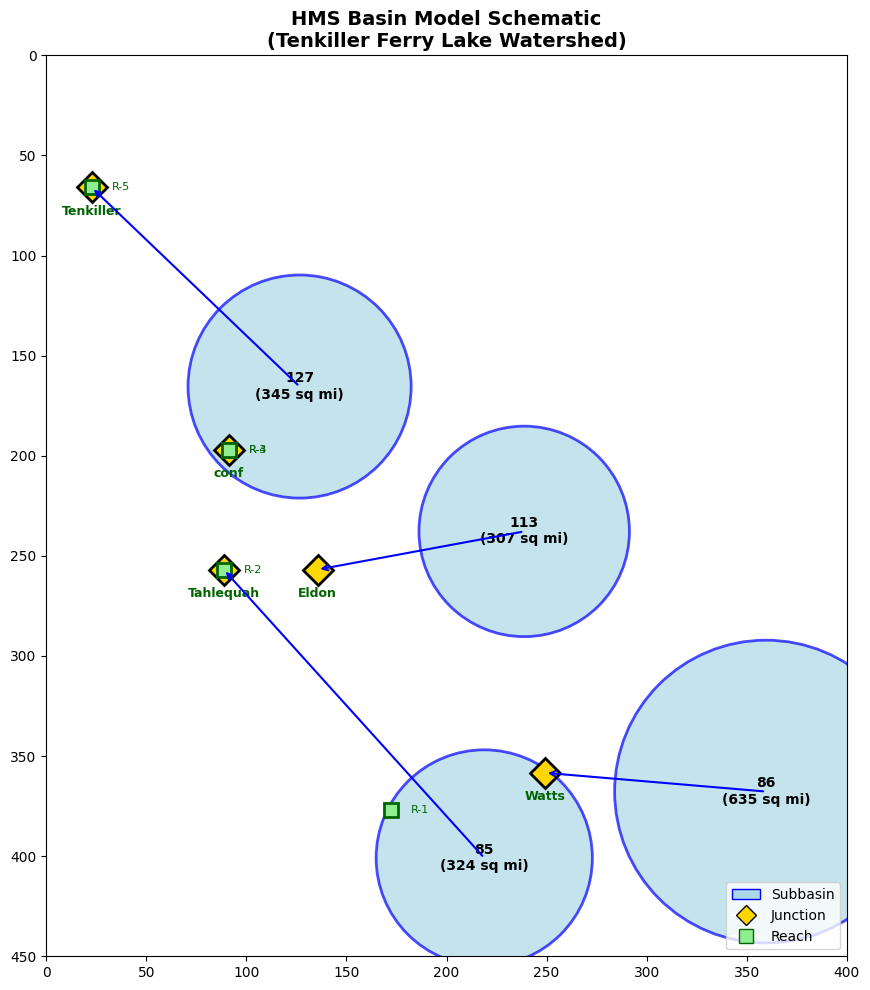

Saved: aorc_workflow_output\hms_basin_schematic.png


In [32]:
# Visualize HMS Basin Model Geometry
from hms_commander import HmsBasin
import numpy as np

basin_files = list(tenk_path.glob('*.basin'))
if basin_files:
    basin_file = str(basin_files[0])
    print(f"Using basin file: {basin_file}")

    subbasins = HmsBasin.get_subbasins(basin_file)
    junctions = HmsBasin.get_junctions(basin_file)
    reaches = HmsBasin.get_reaches(basin_file)

    print(f"\nBasin Model Elements:")
    print(f"  Subbasins: {len(subbasins)}")
    print(f"  Junctions: {len(junctions)}")
    print(f"  Reaches:   {len(reaches)}")

    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot subbasins as circles
    for idx, sub in subbasins.iterrows():
        x, y = float(sub['canvas_x']), float(sub['canvas_y'])
        size = np.sqrt(float(sub['area'])) * 3
        circle = plt.Circle((x, y), size, color='lightblue', ec='blue', linewidth=2, alpha=0.7)
        ax.add_patch(circle)
        ax.annotate(f"{sub['name']}\n({float(sub['area']):.0f} sq mi)",
                    (x, y), ha='center', va='center', fontsize=10, fontweight='bold')

    # Plot junctions as diamonds
    for idx, junc in junctions.iterrows():
        x, y = float(junc['canvas_x']), float(junc['canvas_y'])
        ax.plot(x, y, 'D', markersize=15, color='gold', markeredgecolor='black', markeredgewidth=2)
        ax.annotate(junc['name'], (x, y+15), ha='center', va='bottom', fontsize=9,
                    fontweight='bold', color='darkgreen')

    # Plot reaches as squares
    for idx, reach in reaches.iterrows():
        x, y = float(reach['canvas_x']), float(reach['canvas_y'])
        ax.plot(x, y, 's', markersize=10, color='lightgreen', markeredgecolor='darkgreen', markeredgewidth=2)
        ax.annotate(reach['name'], (x+10, y), ha='left', va='center', fontsize=8, color='darkgreen')

    # Draw connectivity arrows
    for idx, sub in subbasins.iterrows():
        downstream = sub['downstream']
        if downstream and downstream != 'None':
            junc_match = junctions[junctions['name'] == downstream]
            if len(junc_match) > 0:
                x1, y1 = float(sub['canvas_x']), float(sub['canvas_y'])
                x2, y2 = float(junc_match.iloc[0]['canvas_x']), float(junc_match.iloc[0]['canvas_y'])
                ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))

    ax.set_xlim(0, 400)
    ax.set_ylim(0, 450)
    ax.set_aspect('equal')
    ax.set_title('HMS Basin Model Schematic\n(Tenkiller Ferry Lake Watershed)', fontsize=14, fontweight='bold')

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='lightblue', edgecolor='blue', label='Subbasin'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='gold',
               markeredgecolor='black', markersize=10, label='Junction'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgreen',
               markeredgecolor='darkgreen', markersize=10, label='Reach'),
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(output_dir / 'hms_basin_schematic.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {output_dir / 'hms_basin_schematic.png'}")
else:
    print("No basin file found")

### Basin Model Map (Shapefiles)

Error: 'AREA'


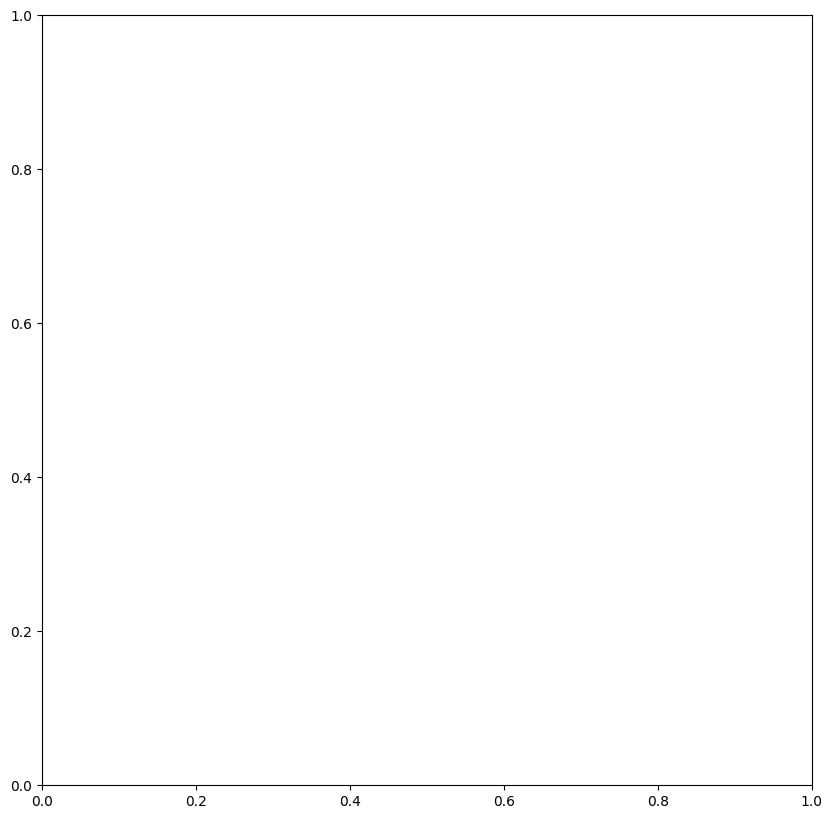

In [33]:
# Visualize with shapefiles if available
try:
    import geopandas as gpd

    subbasins_shp = tenk_path / "maps" / "subbasins.shp"
    rivers_shp = tenk_path / "maps" / "rivers.shp"

    if subbasins_shp.exists():
        subbasins_gdf = gpd.read_file(subbasins_shp)

        fig, ax = plt.subplots(figsize=(12, 10))
        subbasins_gdf.plot(ax=ax, column='AREA', cmap='Blues', edgecolor='darkblue',
                           linewidth=1.5, alpha=0.7, legend=True,
                           legend_kwds={'label': 'Area (sq mi)'})

        if rivers_shp.exists():
            rivers_gdf = gpd.read_file(rivers_shp)
            rivers_gdf.plot(ax=ax, color='blue', linewidth=2)

        for idx, row in subbasins_gdf.iterrows():
            centroid = row.geometry.centroid
            ax.annotate(f"{row['NAME']}\n({row['AREA']:.0f} sq mi)",
                        xy=(centroid.x, centroid.y), ha='center', va='center',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title('Tenkiller Ferry Lake Watershed\nHMS Basin Model Subbasins',
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(output_dir / 'hms_basin_map.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {output_dir / 'hms_basin_map.png'}")
    else:
        print("Shapefiles not found")

except ImportError:
    print("geopandas not available - skipping shapefile visualization")
except Exception as e:
    print(f"Error: {e}")

### Execute HMS Simulation

Run the HMS simulation using the gridded precipitation data.

In [34]:
# Execute HMS - run the first available run
run_name = hms_project.run_df.iloc[0]['name']
print(f"Executing HMS run: {run_name}")
print("=" * 50)

success = HmsCmdr.compute_run(run_name)

if success:
    print(f"\nRun completed successfully!")
else:
    print(f"\nRun failed")

2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Found HEC-HMS: C:\Program Files\HEC\HEC-HMS\4.10


2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Found HEC-HMS: C:\Program Files\HEC\HEC-HMS\4.10


2025-12-21 20:13:32 - hms_commander.HmsCmdr - INFO - Computing run 'Jan 96 storm' in C:\GH\hms-commander\examples\hms_example_projects\tenk


2025-12-21 20:13:32 - hms_commander.HmsCmdr - INFO - Computing run 'Jan 96 storm' in C:\GH\hms-commander\examples\hms_example_projects\tenk


2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Executing HMS 4.10 via direct Java invocation


2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Executing HMS 4.10 via direct Java invocation


2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Script: C:\GH\hms-commander\examples\hms_example_projects\tenk\hms_script.py


2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Script: C:\GH\hms-commander\examples\hms_example_projects\tenk\hms_script.py


2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Memory: -Xms128M -Xmx4G


2025-12-21 20:13:32 - hms_commander.HmsJython - INFO - Memory: -Xms128M -Xmx4G


Executing HMS run: Jan 96 storm


2025-12-21 20:13:34 - hms_commander.HmsJython - INFO - HMS 4.10 script executed successfully


2025-12-21 20:13:34 - hms_commander.HmsJython - INFO - HMS 4.10 script executed successfully


2025-12-21 20:13:34 - hms_commander.HmsCmdr - INFO - Run 'Jan 96 storm' completed successfully


2025-12-21 20:13:34 - hms_commander.HmsCmdr - INFO - Run 'Jan 96 storm' completed successfully



Run completed successfully!


### Analyze Results - Peak Flows

Extract and display peak flow results from the HMS simulation.

In [35]:
# Find the DSS results file (named after the run, not hrap.dss which is input precipitation)
dss_results = list(tenk_path.glob("**/*.dss"))
print(f"Found {len(dss_results)} DSS files:")
for dss in dss_results:
    print(f"  {dss.name}: {dss.stat().st_size / 1024:.1f} KB")

# The results DSS is named after the run (with underscores replacing spaces)
# e.g., "Jan 96 storm" -> "Jan_96_storm.dss"
results_dss = [d for d in dss_results if "hrap" not in d.name.lower() and "tenk" not in d.name.lower()]
if results_dss:
    results_dss = results_dss[0]
    print(f"\nUsing results DSS: {results_dss.name}")

Found 3 DSS files:
  hrap.dss: 1193.5 KB
  Jan_96_storm.dss: 632.5 KB
  tenk.dss: 26.5 KB

Using results DSS: Jan_96_storm.dss


In [36]:
# Extract peak flows from the results DSS file
print(f"Analyzing results from: {results_dss.name}")

try:
    # Get DSS catalog to see what's available
    from ras_commander.dss import RasDss
    catalog = RasDss.get_catalog(str(results_dss))
    
    # Filter for FLOW records
    flow_records = [p for p in catalog if 'FLOW' in p.upper()]
    print(f"\nFlow records found: {len(flow_records)}")
    
    # Get peak flows for all elements
    peaks = HmsResults.get_peak_flows(str(results_dss))
    
    if len(peaks) > 0:
        print(f"\nPeak Flow Summary ({len(peaks)} elements):")
        print("=" * 70)
        print(f"{'Element':<30} {'Peak Flow (cfs)':>15} {'Time to Peak':>20}")
        print("-" * 70)
        
        for element, row in peaks.iterrows():
            peak_flow = row.get('Peak Flow (cfs)', row.get('peak_flow', 'N/A'))
            time_peak = row.get('Time to Peak', row.get('time_to_peak', 'N/A'))
            # Handle both numeric and string peak flow values
            if isinstance(peak_flow, (int, float)):
                print(f"{element:<30} {peak_flow:>15.1f} {str(time_peak):>20}")
            else:
                print(f"{element:<30} {str(peak_flow):>15} {str(time_peak):>20}")
    else:
        # Show DSS catalog if no peaks found
        print("\nNo peak flows extracted. DSS catalog:")
        for path in catalog[:15]:
            print(f"  {path}")
        if len(catalog) > 15:
            print(f"  ... and {len(catalog) - 15} more")
    
except Exception as e:
    print(f"Could not extract peak flows: {e}")

Analyzing results from: Jan_96_storm.dss

Flow records found: 58


2025-12-21 20:13:35 - hms_commander.HmsResults - INFO - Extracted peak flows for 58 elements


2025-12-21 20:13:35 - hms_commander.HmsResults - INFO - Extracted peak flows for 58 elements



Peak Flow Summary (58 elements):
Element                        Peak Flow (cfs)         Time to Peak
----------------------------------------------------------------------
0                              1996-01-21 23:00:00                  N/A
43                             1996-01-21 23:00:00                  N/A
31                             1996-01-21 23:00:00                  N/A
32                             1996-01-21 23:00:00                  N/A
33                             1996-01-21 23:00:00                  N/A
34                             1996-01-21 23:00:00                  N/A
35                             1996-01-21 23:00:00                  N/A
36                             1996-01-21 23:00:00                  N/A
37                             1996-01-21 23:00:00                  N/A
38                             1996-01-21 23:00:00                  N/A
39                             1996-01-21 23:00:00                  N/A
40                             1996

### Per-Subbasin Peak Flow Analysis

Detailed flow analysis for each element showing peak flows with storm labels.

In [37]:
# Analyze all flow records from DSS
from ras_commander.dss import RasDss

catalog = RasDss.get_catalog(str(results_dss))
print(f"Total DSS records: {len(catalog)}")

flow_records = [p for p in catalog if '/FLOW/' in p.upper()
                and 'OBSERVED' not in p.upper()
                and 'CUMULATIVE' not in p.upper()
                and 'RESIDUAL' not in p.upper()
                and 'COMBINE' not in p.upper()]

print(f"Flow records: {len(flow_records)}")

Total DSS records: 94
Flow records: 14


In [38]:
# Extract peak flows for each element
element_peaks = {}

for pathname in flow_records:
    parts = pathname.split('/')
    if len(parts) >= 3:
        element_name = parts[2]

        try:
            ts = RasDss.read_timeseries(str(results_dss), pathname)
            if ts is not None and len(ts) > 0:
                vals = ts.values.flatten() if ts.values.ndim > 1 else ts.values
                peak_val = float(vals.max())
                peak_idx = int(vals.argmax())
                peak_time = ts.index[peak_idx]

                if element_name not in element_peaks:
                    element_peaks[element_name] = []
                element_peaks[element_name].append({
                    'pathname': pathname,
                    'peak_flow': peak_val,
                    'peak_time': peak_time,
                    'parameter': parts[3] if len(parts) > 3 else 'FLOW'
                })
        except:
            pass

print(f"Elements with peak flows: {len(element_peaks)}")
for elem, peaks in element_peaks.items():
    print(f"  {elem}: {len(peaks)} records, max peak: {max(p['peak_flow'] for p in peaks):.0f} cfs")

Elements with peak flows: 14
  86: 1 records, max peak: 6700 cfs
  WATTS: 1 records, max peak: 6700 cfs
  R-1: 1 records, max peak: 6106 cfs
  R-2: 1 records, max peak: 5644 cfs
  85: 1 records, max peak: 679 cfs
  TAHLEQUAH: 1 records, max peak: 5934 cfs
  R-3: 1 records, max peak: 5837 cfs
  113: 1 records, max peak: 6546 cfs
  ELDON: 1 records, max peak: 6546 cfs
  R-4: 1 records, max peak: 6202 cfs
  CONF: 1 records, max peak: 6847 cfs
  R-5: 1 records, max peak: 6847 cfs
  127: 1 records, max peak: 5713 cfs
  TENKILLER: 1 records, max peak: 7656 cfs


### Peak Flow Summary Chart

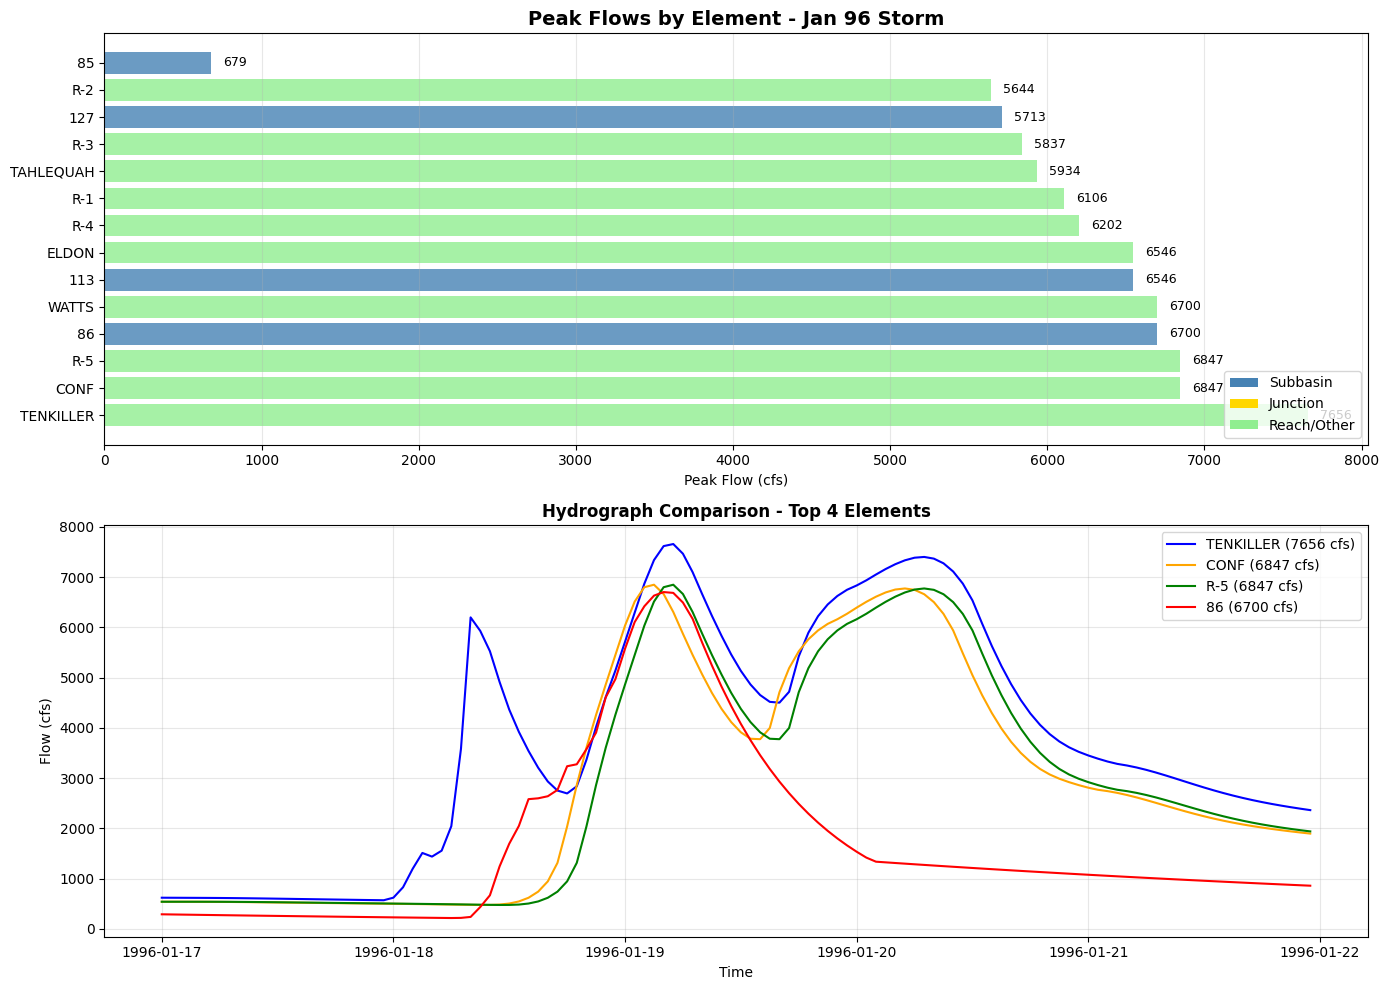

Saved: aorc_workflow_output\peak_flow_summary.png


In [39]:
# Get element categories from basin model
subbasin_names = set(subbasins['name'].tolist()) if len(subbasins) > 0 else set()
junction_names = set(junctions['name'].tolist()) if len(junctions) > 0 else set()

# Create peak flow summary visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Get max peak for each element
all_elements = {}
for elem, peaks in element_peaks.items():
    max_peak = max(peaks, key=lambda x: x['peak_flow'])
    all_elements[elem] = max_peak['peak_flow']

sorted_elements = sorted(all_elements.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in sorted_elements]
values = [x[1] for x in sorted_elements]

colors = []
for name in names:
    if name in subbasin_names:
        colors.append('steelblue')
    elif name in junction_names:
        colors.append('gold')
    else:
        colors.append('lightgreen')

ax1 = axes[0]
bars = ax1.barh(range(len(names)), values, color=colors, alpha=0.8)
ax1.set_yticks(range(len(names)))
ax1.set_yticklabels(names)
ax1.set_xlabel('Peak Flow (cfs)')
ax1.set_title('Peak Flows by Element - Jan 96 Storm', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

for i, (name, val) in enumerate(sorted_elements):
    ax1.text(val + max(values)*0.01, i, f'{val:.0f}', va='center', fontsize=9)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Subbasin'),
    Patch(facecolor='gold', label='Junction'),
    Patch(facecolor='lightgreen', label='Reach/Other'),
]
ax1.legend(handles=legend_elements, loc='lower right')

# Hydrograph comparison
ax2 = axes[1]
colors_line = ['blue', 'orange', 'green', 'red']

for i, (elem_name, _) in enumerate(sorted_elements[:4]):
    if elem_name in element_peaks:
        peak_info = element_peaks[elem_name][0]
        pathname = peak_info['pathname']

        try:
            ts = RasDss.read_timeseries(str(results_dss), pathname)
            if ts is not None and len(ts) > 0:
                vals = ts.values.flatten() if ts.values.ndim > 1 else ts.values
                ax2.plot(ts.index, vals, color=colors_line[i], linewidth=1.5,
                         label=f"{elem_name} ({peak_info['peak_flow']:.0f} cfs)")
        except:
            pass

ax2.set_xlabel('Time')
ax2.set_ylabel('Flow (cfs)')
ax2.set_title('Hydrograph Comparison - Top 4 Elements', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'peak_flow_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {output_dir / 'peak_flow_summary.png'}")

### Individual Subbasin Flow Components

Flow analysis for each subbasin showing direct flow, baseflow, and combined outflow with peak labels.

In [40]:
# Create individual figure for each subbasin
print(f"Generating per-subbasin flow figures...")
print("=" * 70)

for sub_name in subbasin_names:
    sub_records = [p for p in flow_records if f'/{sub_name}/' in p]
    if len(sub_records) == 0:
        continue

    fig, ax = plt.subplots(figsize=(12, 6))

    sub_row = subbasins[subbasins['name'] == sub_name]
    area = float(sub_row['area'].iloc[0]) if len(sub_row) > 0 else 0

    peak_annotations = []

    for pathname in sub_records:
        parts = pathname.split('/')
        flow_type = parts[3] if len(parts) > 3 else 'FLOW'

        try:
            ts = RasDss.read_timeseries(str(results_dss), pathname)
            if ts is not None and len(ts) > 0:
                vals = ts.values.flatten() if ts.values.ndim > 1 else ts.values

                if 'DIRECT' in flow_type.upper():
                    color, label = 'blue', 'Direct Flow'
                elif 'BASE' in flow_type.upper():
                    color, label = 'brown', 'Baseflow'
                else:
                    color, label = 'green', flow_type

                ax.plot(ts.index, vals, color=color, linewidth=1.5, label=label, alpha=0.8)

                peak_val = float(vals.max())
                peak_idx = int(vals.argmax())
                peak_time = ts.index[peak_idx]
                peak_annotations.append((peak_time, peak_val, label))

        except:
            pass

    for peak_time, peak_val, label in peak_annotations:
        ax.annotate(f'{label}\nPeak: {peak_val:.0f} cfs',
                    xy=(peak_time, peak_val),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    ax.set_xlabel('Time')
    ax.set_ylabel('Flow (cfs)')
    ax.set_title(f'Subbasin {sub_name} - Flow Components\nArea: {area:.0f} sq mi | Jan 96 Storm',
                 fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(output_dir / f'subbasin_{sub_name}_flows.png', dpi=150, bbox_inches='tight')
    plt.close()

    print(f"  Subbasin {sub_name}: Saved subbasin_{sub_name}_flows.png")

print(f"\nAll subbasin figures saved to: {output_dir}")

Generating per-subbasin flow figures...


  Subbasin 85: Saved subbasin_85_flows.png


  Subbasin 86: Saved subbasin_86_flows.png


  Subbasin 113: Saved subbasin_113_flows.png


  Subbasin 127: Saved subbasin_127_flows.png

All subbasin figures saved to: aorc_workflow_output


### Junction Outflow Hydrographs

Outflow hydrographs at key watershed junctions with peak flow annotations.

In [41]:
# Create combined junction figure
junction_flow_records = {name: [] for name in junction_names}

for pathname in flow_records:
    parts = pathname.split('/')
    if len(parts) >= 3:
        elem = parts[2]
        if elem in junction_names:
            junction_flow_records[elem].append(pathname)

active_junctions = {k: v for k, v in junction_flow_records.items() if len(v) > 0}
print(f"Junctions with flow data: {len(active_junctions)}")

if len(active_junctions) > 0:
    n_junctions = len(active_junctions)
    fig, axes = plt.subplots(n_junctions, 1, figsize=(14, 4*n_junctions), sharex=True)
    if n_junctions == 1:
        axes = [axes]

    for i, (junc_name, pathnames) in enumerate(sorted(active_junctions.items())):
        ax = axes[i]

        for pathname in pathnames:
            parts = pathname.split('/')
            flow_type = parts[3] if len(parts) > 3 else 'FLOW'

            if flow_type.upper() == 'FLOW':
                try:
                    ts = RasDss.read_timeseries(str(results_dss), pathname)
                    if ts is not None and len(ts) > 0:
                        vals = ts.values.flatten() if ts.values.ndim > 1 else ts.values
                        ax.plot(ts.index, vals, 'b-', linewidth=2, label='Outflow')

                        peak_val = float(vals.max())
                        peak_idx = int(vals.argmax())
                        peak_time = ts.index[peak_idx]

                        ax.annotate(f'Peak: {peak_val:.0f} cfs\nJan 96 Storm',
                                    xy=(peak_time, peak_val),
                                    xytext=(20, 0), textcoords='offset points',
                                    fontsize=10, fontweight='bold',
                                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
                                    arrowprops=dict(arrowstyle='->', color='red', lw=2))

                except:
                    pass

        ax.set_ylabel('Flow (cfs)')
        ax.set_title(f'Junction: {junc_name}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')

    axes[-1].set_xlabel('Time')
    axes[-1].tick_params(axis='x', rotation=45)

    plt.suptitle('Junction Outflow Hydrographs - Jan 96 Storm\nTenkiller Ferry Lake Watershed',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(output_dir / 'junction_outflows.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {output_dir / 'junction_outflows.png'}")
else:
    print("No junction flow data available")

Junctions with flow data: 0
No junction flow data available


Plotting hydrograph for: //86/FLOW-DIRECT/01JAN1996/1HOUR/RUN:JAN 96 STORM/


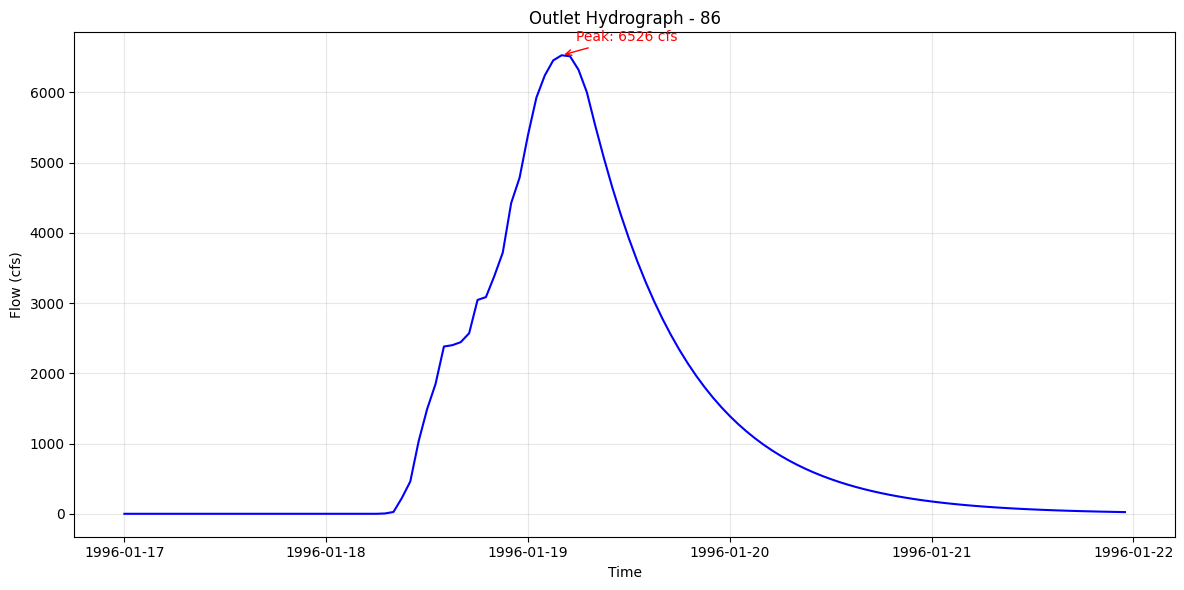

Saved: aorc_workflow_output\outlet_hydrograph.png


In [42]:
# Plot outlet hydrograph (if matplotlib available)
try:
    import matplotlib.pyplot as plt
    from ras_commander.dss import RasDss
    
    # Get DSS catalog and find FLOW records
    catalog = RasDss.get_catalog(str(results_dss))
    flow_records = [p for p in catalog if 'FLOW' in p.upper() and 'OBSERVED' not in p.upper()]
    
    if flow_records:
        # Use first flow record
        pathname = flow_records[0]
        print(f"Plotting hydrograph for: {pathname}")
        
        # Extract timeseries using correct method name
        ts = RasDss.read_timeseries(str(results_dss), pathname)
        
        if ts is not None and len(ts) > 0:
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Get values as 1D array
            if hasattr(ts, 'values'):
                vals = ts.values.flatten() if ts.values.ndim > 1 else ts.values
            else:
                vals = ts.flatten() if ts.ndim > 1 else ts
            
            ax.plot(ts.index, vals, 'b-', linewidth=1.5)
            ax.set_xlabel('Time')
            ax.set_ylabel('Flow (cfs)')
            
            # Extract element name from pathname
            parts = pathname.split('/')
            element_name = parts[2] if len(parts) > 2 else 'Outlet'
            ax.set_title(f'Outlet Hydrograph - {element_name}')
            ax.grid(True, alpha=0.3)
            
            # Add peak flow annotation
            peak_idx = int(vals.argmax())
            peak_time = ts.index[peak_idx]
            peak_val = float(vals[peak_idx])
            ax.annotate(f'Peak: {peak_val:.0f} cfs', 
                        xy=(peak_time, peak_val),
                        xytext=(10, 10), textcoords='offset points',
                        fontsize=10, color='red',
                        arrowprops=dict(arrowstyle='->', color='red'))
            
            plt.tight_layout()
            plt.savefig(output_dir / 'outlet_hydrograph.png', dpi=150)
            plt.show()
            print(f"Saved: {output_dir / 'outlet_hydrograph.png'}")
        else:
            print("Could not read timeseries data")
    else:
        print("No FLOW records found in DSS (excluding observed)")
        
except Exception as e:
    print(f"Could not plot hydrograph: {e}")


---

## Complete Workflow Summary

All phases of the AORC gridded precipitation workflow have been completed.

In [43]:
print("=" * 70)
print("COMPLETE AORC GRIDDED PRECIPITATION WORKFLOW")
print("=" * 70)

print("\n[OK] Phase 1 - HUC Watersheds:")
print(f"    Downloaded {len(watersheds)} HUC12 watersheds ({watersheds['areasqkm'].sum():.1f} km2)")

print("\n[OK] Phase 2 - AORC Precipitation:")
print(f"    Storm event: {largest_storm['total_depth_in']:.2f} inches over {largest_storm['duration_hours']} hours")
print(f"    NetCDF file: {nc_file.name} ({nc_file.stat().st_size / (1024*1024):.2f} MB)")
print(f"    DSS grid file: {dss_file.name} ({dss_file.stat().st_size / (1024*1024):.2f} MB)")

print("\n[OK] Phase 3 - HMS Grid Configuration:")
print(f"    Grid definition: {grid_file.name}")
print(f"    Grid cell mapping: {hrapcells_file.name} ({total_cells} cells)")

print("\n[OK] Phase 4 - HMS Execution:")
print(f"    Project: {hms_project.project_name}")
print(f"    Run: {run_name}")
if 'peaks' in dir() and hasattr(peaks, 'columns') and len(peaks) > 0:
    try:
        max_peak = float(peaks.iloc[:, 0].max())
        print(f"    Maximum peak flow: {max_peak:.1f} cfs")
    except (ValueError, TypeError):
        print(f"    Peak flows extracted: {len(peaks)} elements")

print("\n" + "=" * 70)
print(f"Workflow completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

COMPLETE AORC GRIDDED PRECIPITATION WORKFLOW

[OK] Phase 1 - HUC Watersheds:
    Downloaded 23 HUC12 watersheds (2150.5 km2)

[OK] Phase 2 - AORC Precipitation:
    Storm event: 2.70 inches over 32 hours
    NetCDF file: aorc_storm.nc (0.40 MB)
    DSS grid file: aorc_storm.dss (0.34 MB)

[OK] Phase 3 - HMS Grid Configuration:
    Grid definition: aorc.grid
    Grid cell mapping: hrapcells (360 cells)

[OK] Phase 4 - HMS Execution:
    Project: tenk
    Run: Jan 96 storm

Workflow completed: 2025-12-21 20:13:37


---

## Next Steps: Using in HEC-HMS

To use these files in an HEC-HMS project:

1. **Copy files to HMS project folder**:
   - `aorc_storm.dss` - Grid data
   - `aorc.grid` - Grid definition
   - `hrapcells` - Grid cell mapping

2. **Configure Meteorologic Model**:
   - Create new Met Model with type "Gridded Precipitation"
   - Select the grid definition (AORC_BaldEagle)
   - Associate subbasins with hrapcells regions

3. **Configure Basin Model**:
   - Create subbasins matching HUC12 names
   - Set transform method to "ModClark" for distributed routing

4. **Run Simulation**:
   - Create control specification covering storm period
   - Create run combining basin, met, and control
   - Execute and analyze results

In [44]:
# HMS integration preview
print("Files for HMS Project:")
print("\n1. Copy to HMS project folder:")
for f in [dss_file, grid_file, hrapcells_file]:
    print(f"   {f.name}")

print("\n2. HMS Met Model configuration:")
print(f"   Grid Type: Precipitation")
print(f"   Grid Name: {grid_metadata['grids'][0]['grid_name']}")
print(f"   DSS Pathname: {grid_metadata['grids'][0]['pathname']}")

print("\n3. Subbasin names for Basin Model:")
for huc in subbasin_geometries.keys():
    name = watersheds[watersheds['huc12'] == huc]['name'].iloc[0]
    print(f"   {huc} ({name})")

Files for HMS Project:

1. Copy to HMS project folder:
   aorc_storm.dss
   aorc.grid
   hrapcells

2. HMS Met Model configuration:
   Grid Type: Precipitation
   Grid Name: AORC_BaldEagle
   DSS Pathname: /AORC/BALDEAGLE/PRECIP////

3. Subbasin names for Basin Model:
   020502030404 (Baker Run)
   020502030405 (North Fork Tangascootack Creek)
   020502030406 (Tangascootack Creek)
   020502030407 (Lick Run)
   020502030408 (Ferney Run-West Branch Susquehanna River)


---

## Additional Resources

- **HmsHuc API**: `help(HmsHuc)` - HUC watershed operations
- **HmsAorc API**: `help(HmsAorc)` - AORC data operations
- **HmsGrid API**: `help(HmsGrid)` - Grid file operations
- **Example Project**: `tenk` in HMS examples has gridded precipitation
- **AORC Documentation**: https://registry.opendata.aws/noaa-nws-aorc/

In [45]:
print(f"\nWorkflow completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Workflow completed: 2025-12-21 20:13:37
